# Introduction
To execute this notebook, be sure to have a collection file json containing lorawan uplink/downlink message named ```wss_messages.json``` to compute the following analysis

In [15]:
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, OrderedDict
from enum import Enum


In [20]:
class Field(Enum):
    content = "content"
    MIC = "MIC"
    DevAddr = "DevAddr"
    upinfo = "upinfo"
    xtime = "xtime"
    rxtime = "rxtime"
    FRMPayload = "FRMPayload"

# Extract any property for all address

In [34]:
def extract_for_all_devaddr(input_file, property_name):
    with open(input_file, 'r') as f:
        data = json.load(f)
    
    devaddr_values = defaultdict(list)
    
    if isinstance(data, list):
        for item in data:
            if Field.content.value in item:
                devaddr = item[Field.content.value].get(Field.DevAddr.value)
                if devaddr is not None:
                    if property_name in item[Field.content.value]:
                        if property_name == Field.FRMPayload.value: # convert to int as it is easier to compute than string
                            # the string representation of FRMPayload would not be used
                            devaddr_values[devaddr].append(int.from_bytes(bytes.fromhex(item[Field.content.value][property_name]), byteorder='big'))
                        else:
                            devaddr_values[devaddr].append(item[Field.content.value][property_name])
                    elif Field.upinfo.value in item[Field.content.value] and property_name in item[Field.content.value][Field.upinfo.value]:
                        devaddr_values[devaddr].append(item[Field.content.value][Field.upinfo.value][property_name])
    else:
        print('please provide an array')

    sorted_devaddr_values = OrderedDict(sorted(devaddr_values.items()))
    return sorted_devaddr_values


# Extract all xtime and rxtime for each devAddr

In [4]:
def extract_xtime_rxtime(input_file):
    with open(input_file, 'r') as f:
        data = json.load(f)
    
    devaddr_values = defaultdict(list)
    
    if isinstance(data, list):
        for item in data:
            if Field.content.value in item:
                devaddr = item[Field.content.value].get(Field.DevAddr.value)
                if devaddr is not None and Field.upinfo.value in item[Field.content.value]:
                    xtime = item[Field.content.value][Field.upinfo.value].get(Field.xtime.value)
                    rxtime = item[Field.content.value][Field.upinfo.value].get(Field.rxtime.value)
                    if xtime is not None and rxtime is not None:
                        devaddr_values[devaddr].append({Field.xtime.value: xtime, Field.rxtime.value: rxtime})
    else:
        print('please provide an array')
        
    sorted_devaddr_values = OrderedDict(sorted(devaddr_values.items()))
    
    return sorted_devaddr_values


In [8]:
file = 'wss_messages.json'
# all_rxtime_by_devAdr= extract_for_all_devaddr(file, 'rxtime')
devaddr_values = extract_xtime_rxtime(file)
print(devaddr_values)

NameError: name 'extract_xtime_rxtime' is not defined

# Export value to json

In [5]:
def save_to_json(val, output_file):
    output_data = {"devAddresses": val}
    with open(output_file, 'w') as f:
        json.dump(output_data, f, indent=4)

In [7]:
save_to_json(devaddr_values, 'times_by_devAddr.json')

# Plot the linear regression between xtime and rxtime

In [21]:
def plot_linear_regression(ax, devaddr, values):
    x = np.array([v[Field.xtime.value] for v in values])
    y = np.array([v[Field.rxtime.value] for v in values])

    # obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(x, y, 1)

    # add linear regression line to scatterplot 
    ax.scatter(x, y, color='blue')
    ax.plot(x, m * x + b, color='red')
    ax.set_xlabel(Field.xtime.value)
    ax.set_ylabel(Field.rxtime.value)
    ax.set_title(devaddr)

def linear_regression(devaddr_values):
    # filter data to process only if >1
    filtered_devaddr_values = {devaddr: values for devaddr, values in devaddr_values.items() if len(values) > 1}
    
    num_devaddresses = len(filtered_devaddr_values)
    num_cols = 5
    num_rows = -(-num_devaddresses // num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 2))
    fig.suptitle(f'Linear regression for every device between {Field.xtime.value} and {Field.rxtime.value}')
    axes = axes.flatten()

    for idx, (devaddr, values) in enumerate(filtered_devaddr_values.items()):
        plot_linear_regression(axes[idx], devaddr, values)

    for i in range(len(filtered_devaddr_values), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout(rect=[0, 0, 1, 0.98]) 
    plt.show()

# linear_regression(devaddr_values)


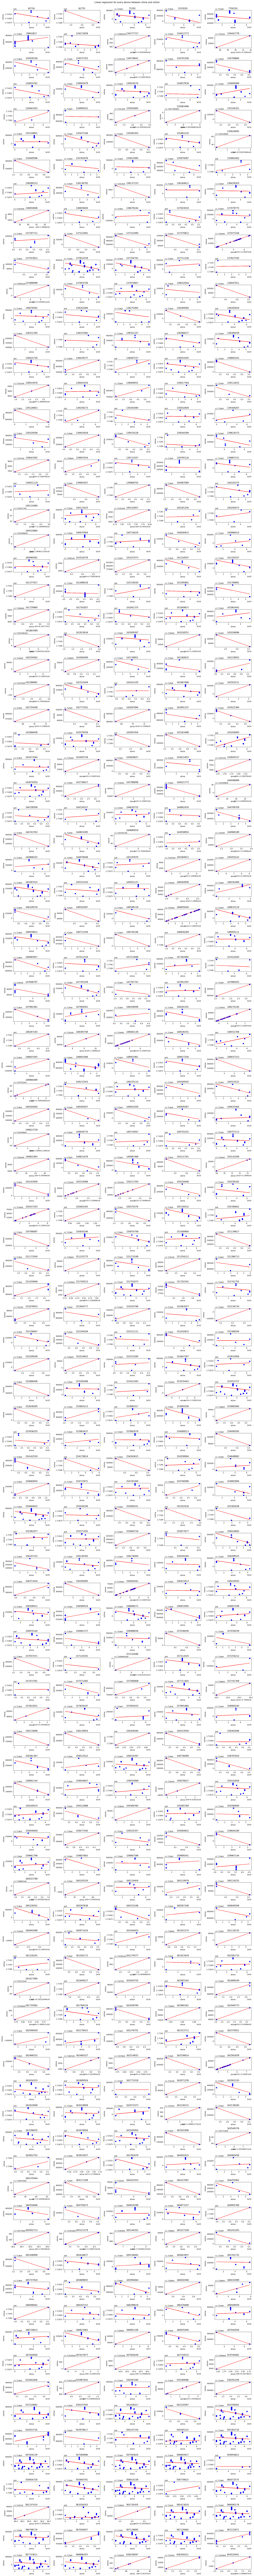

In [22]:
linear_regression(devaddr_values)
#print(regression_results)

# MIC bit level distribution 

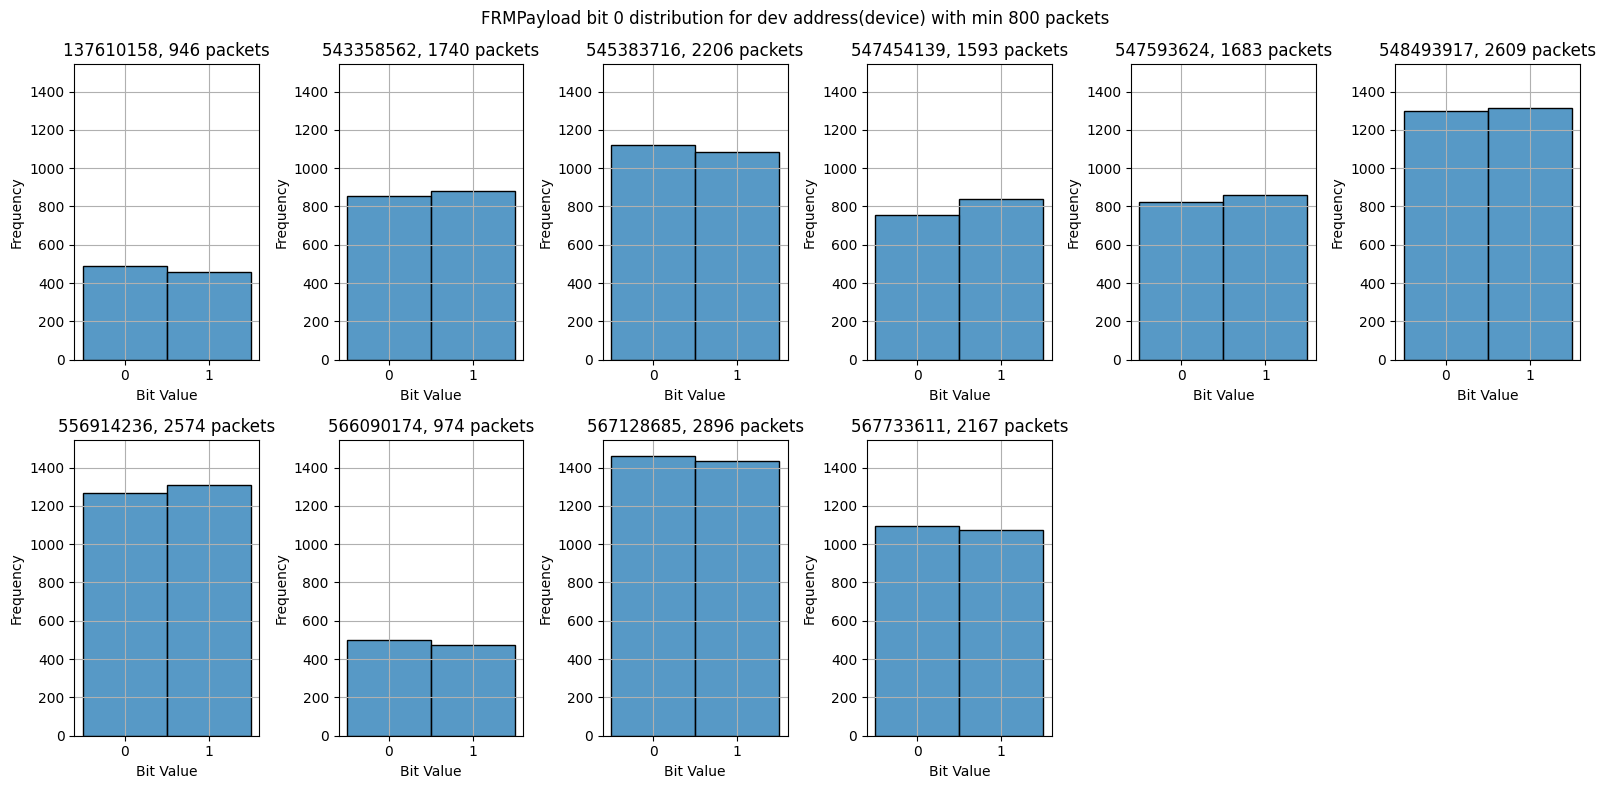

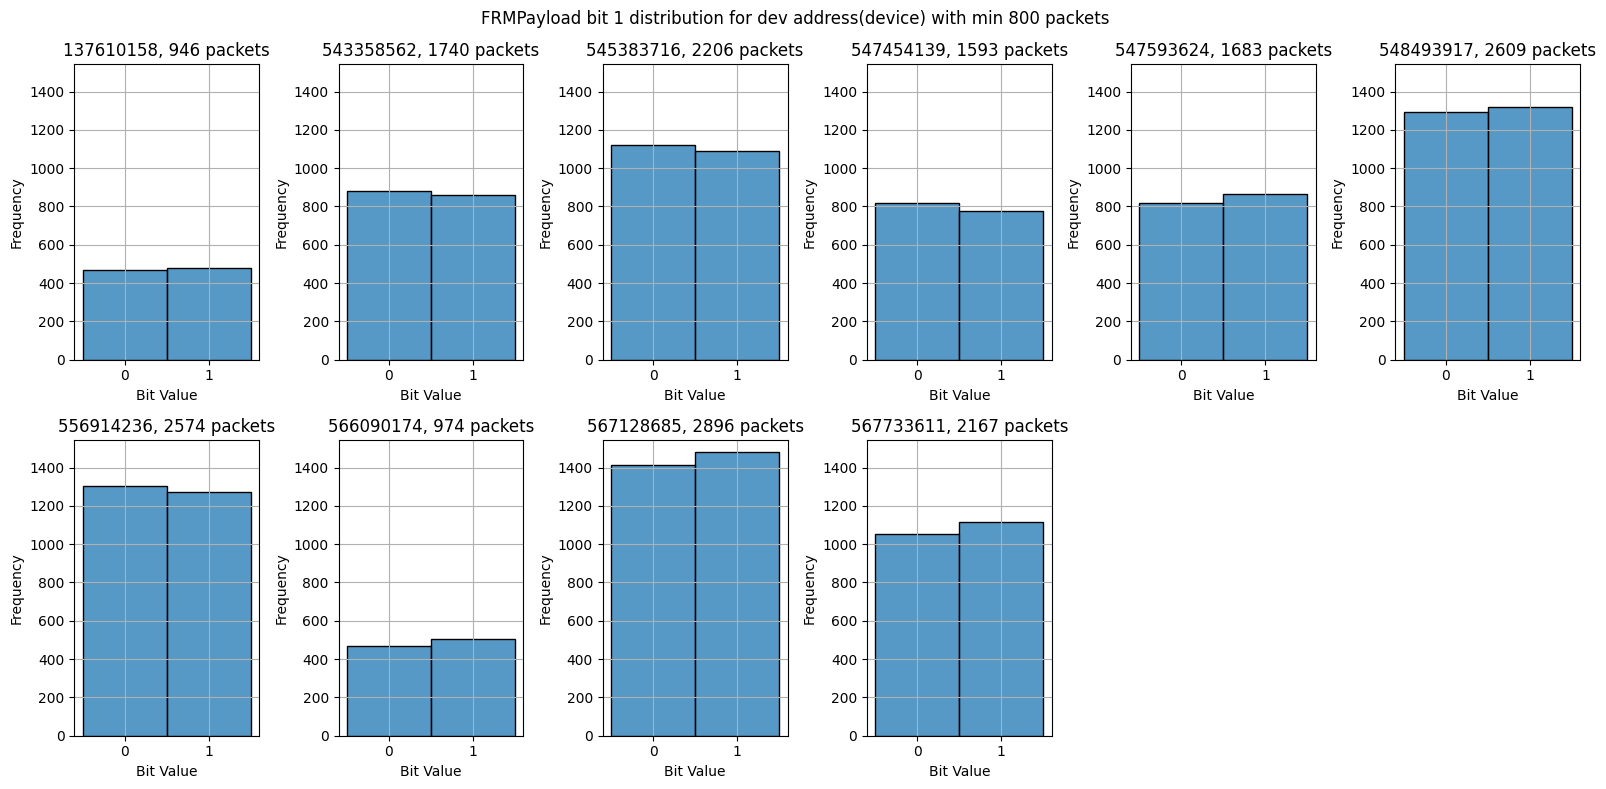

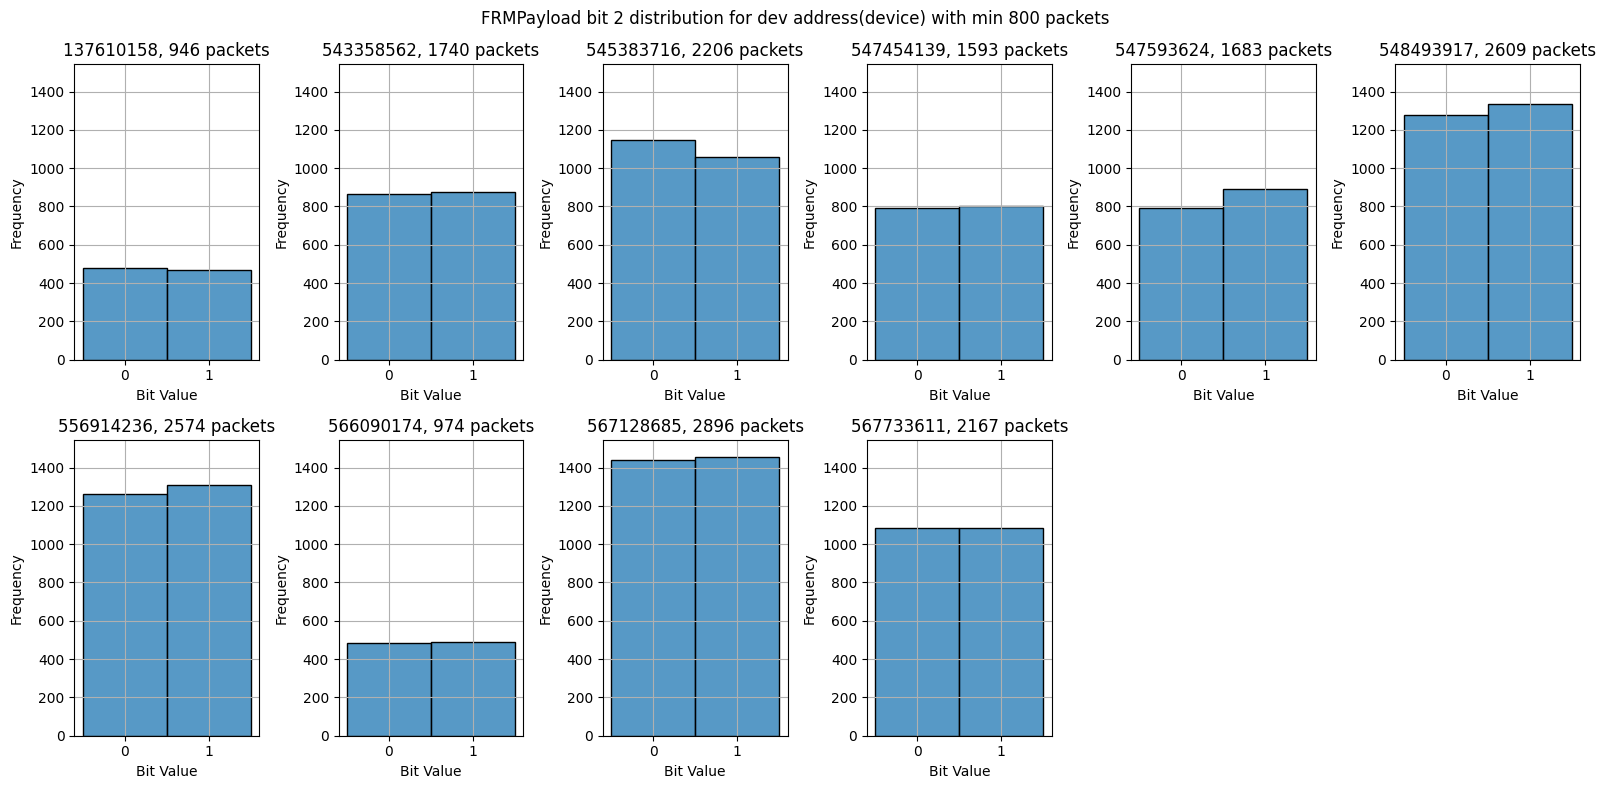

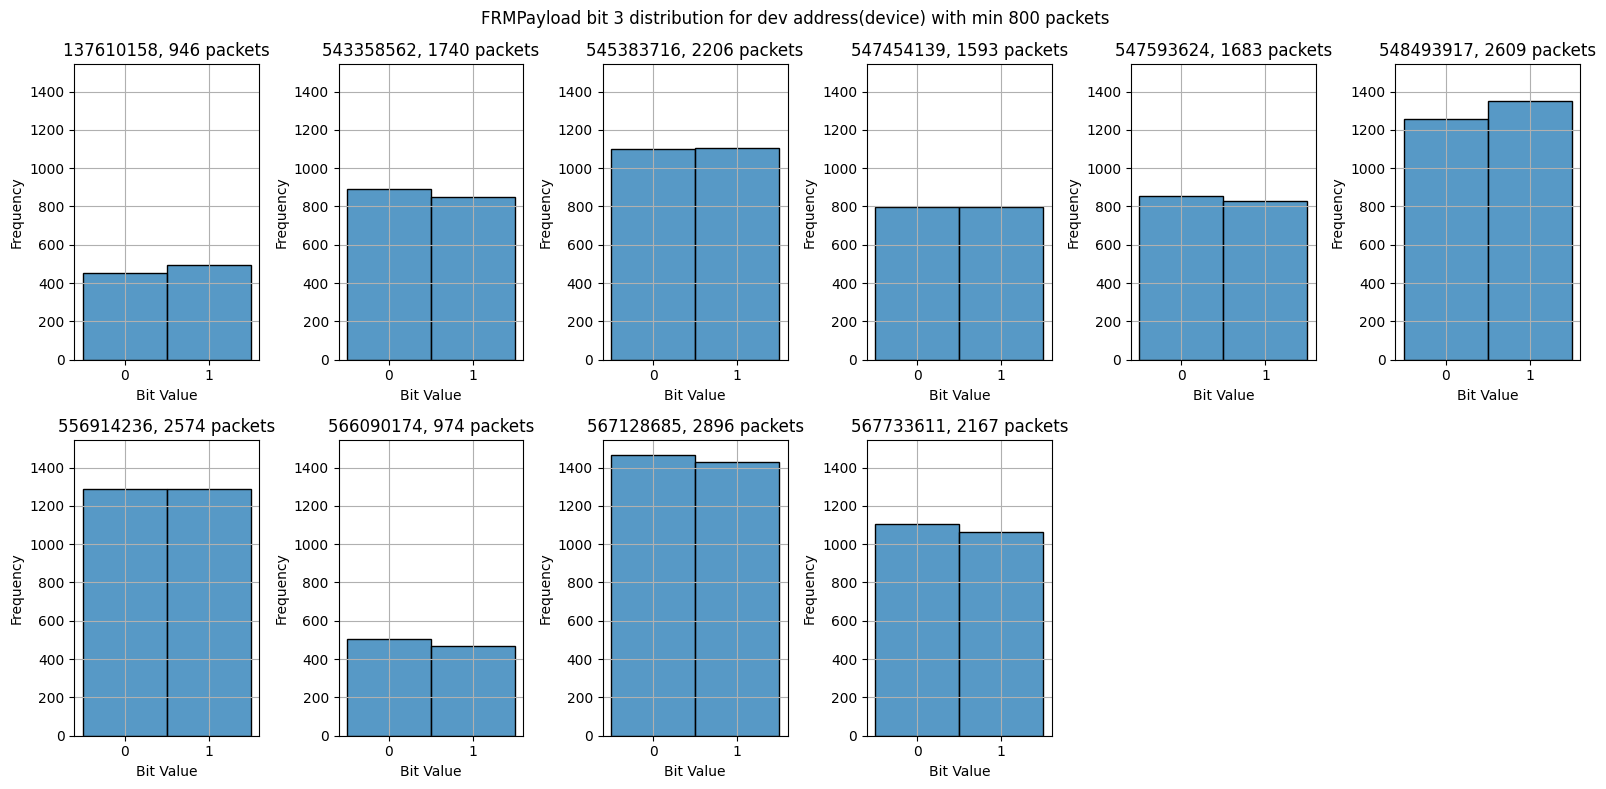

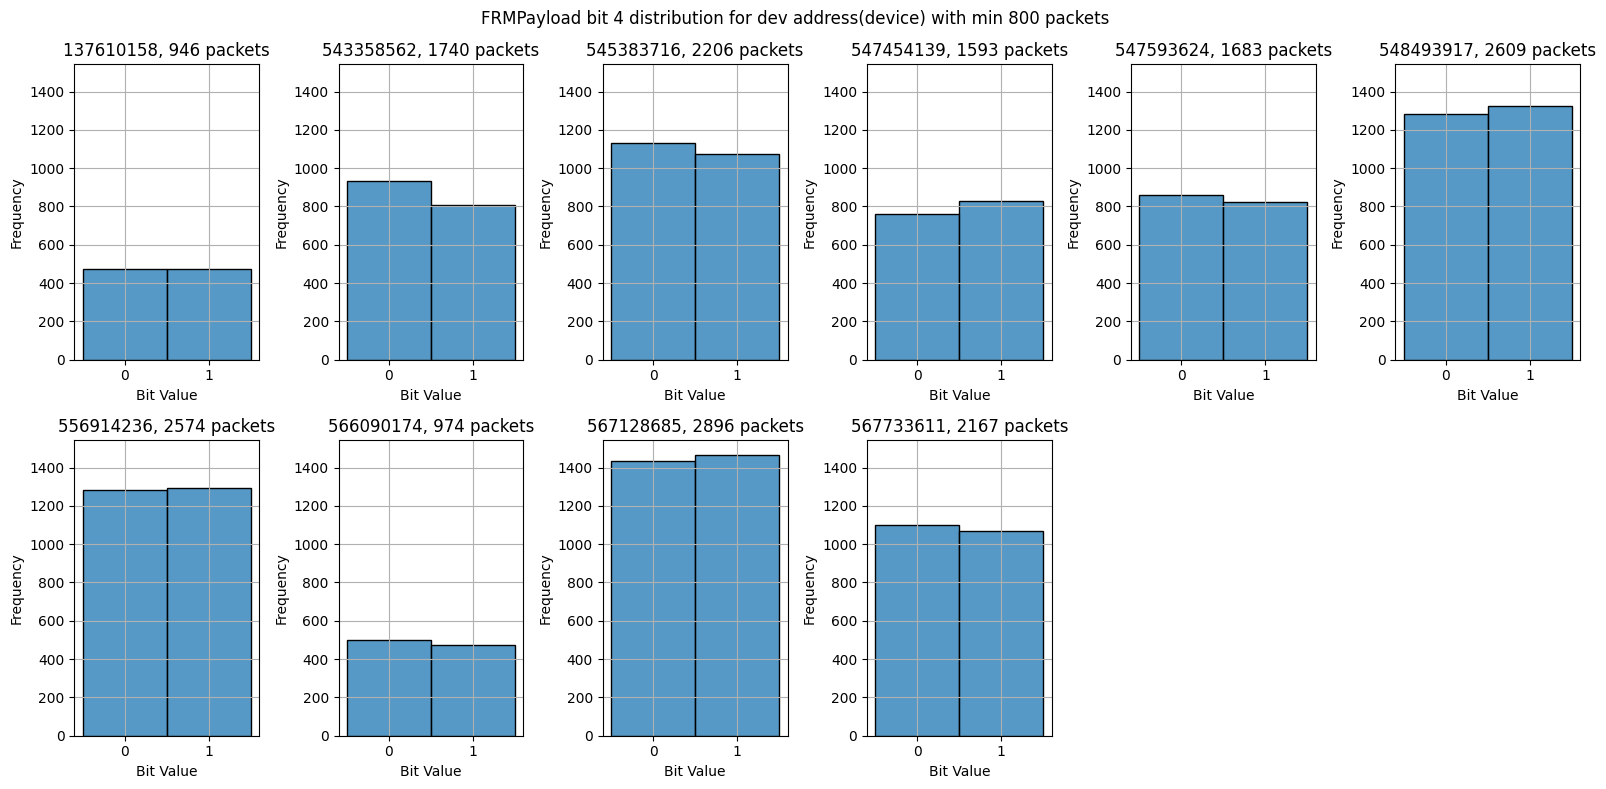

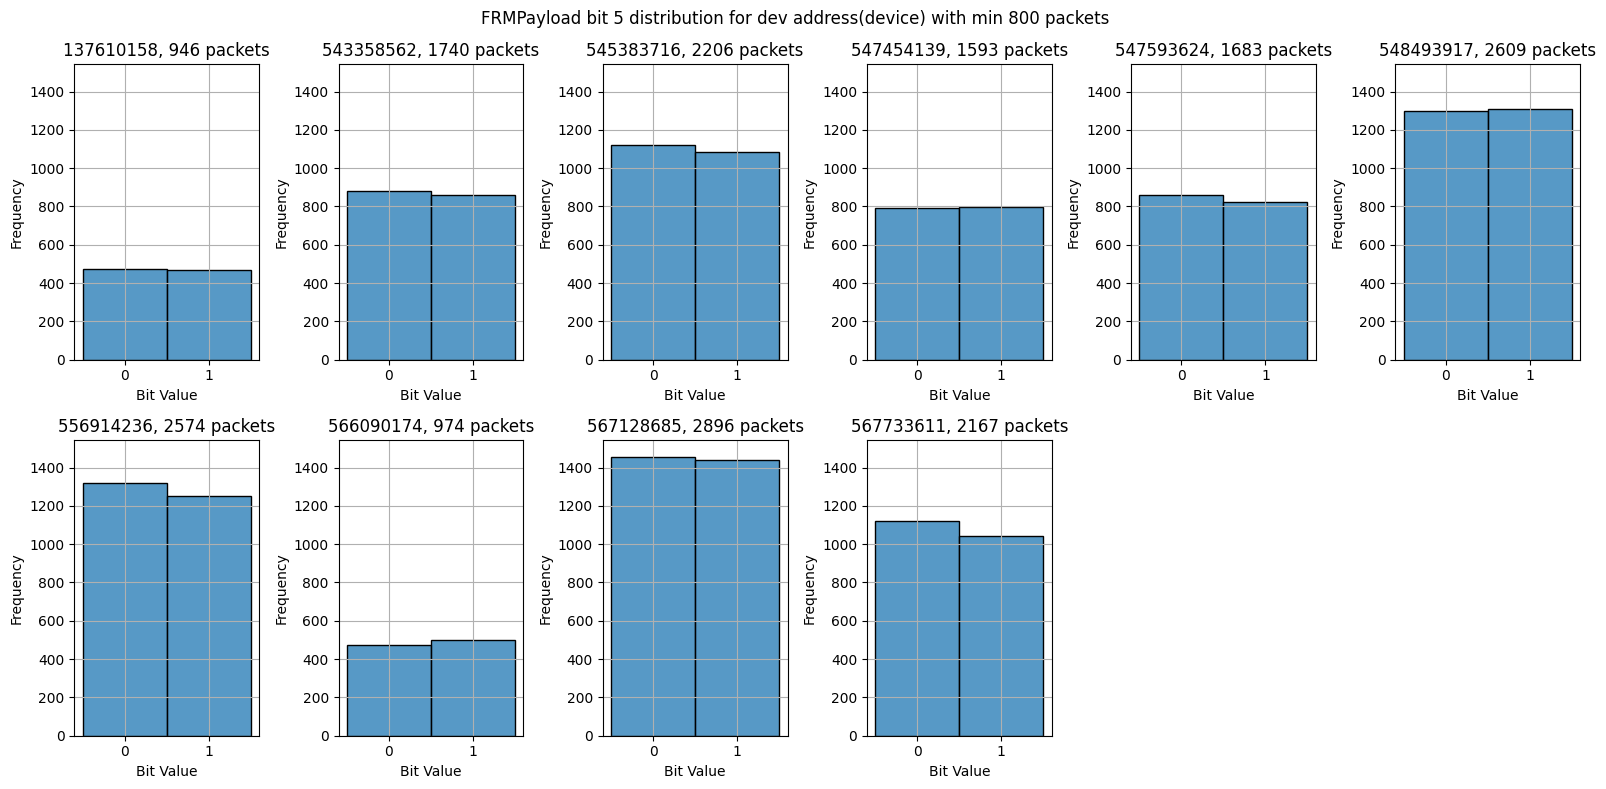

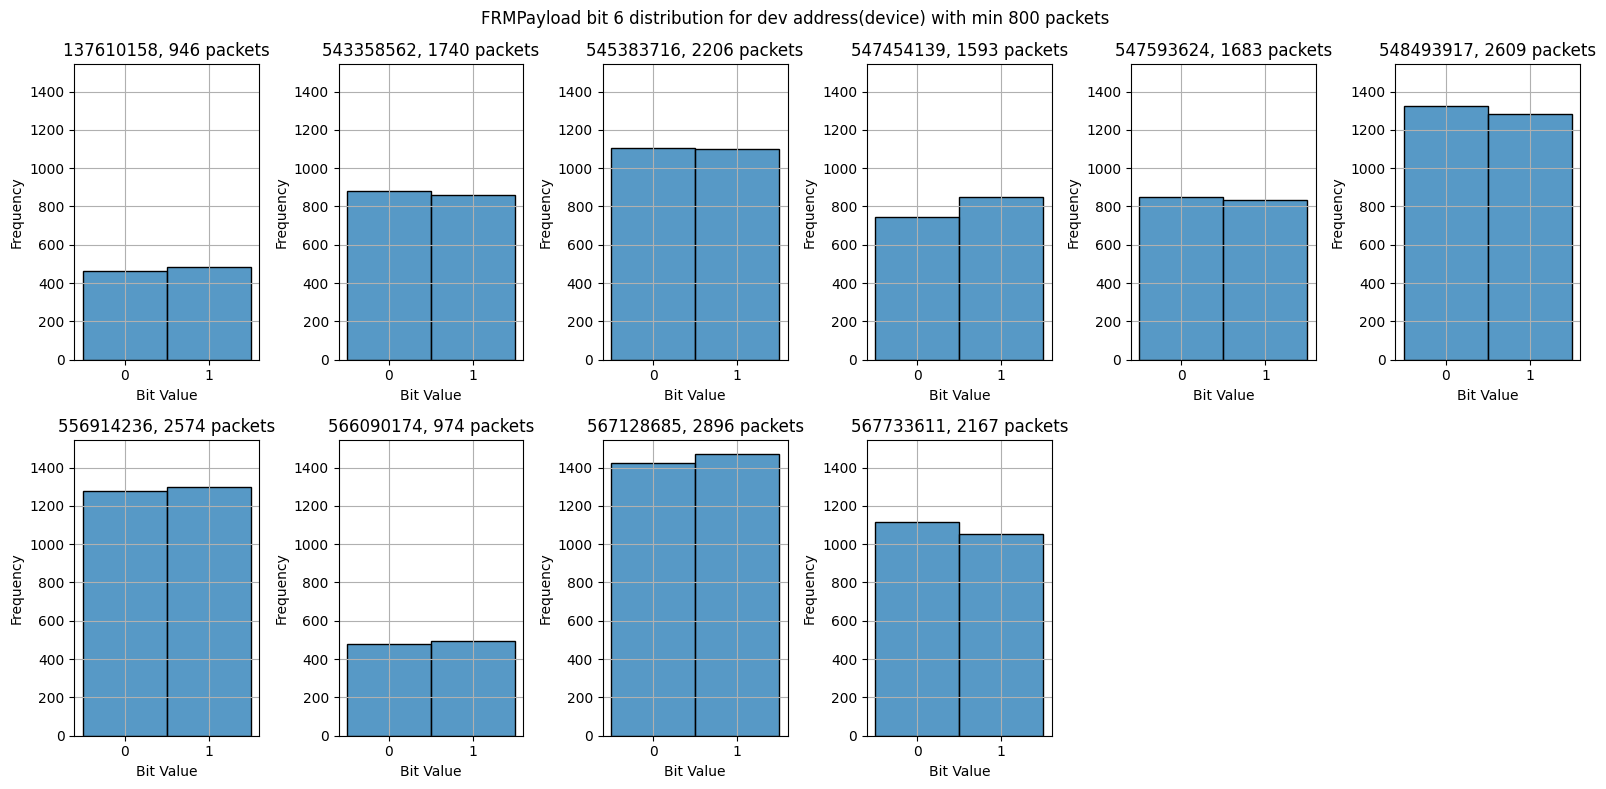

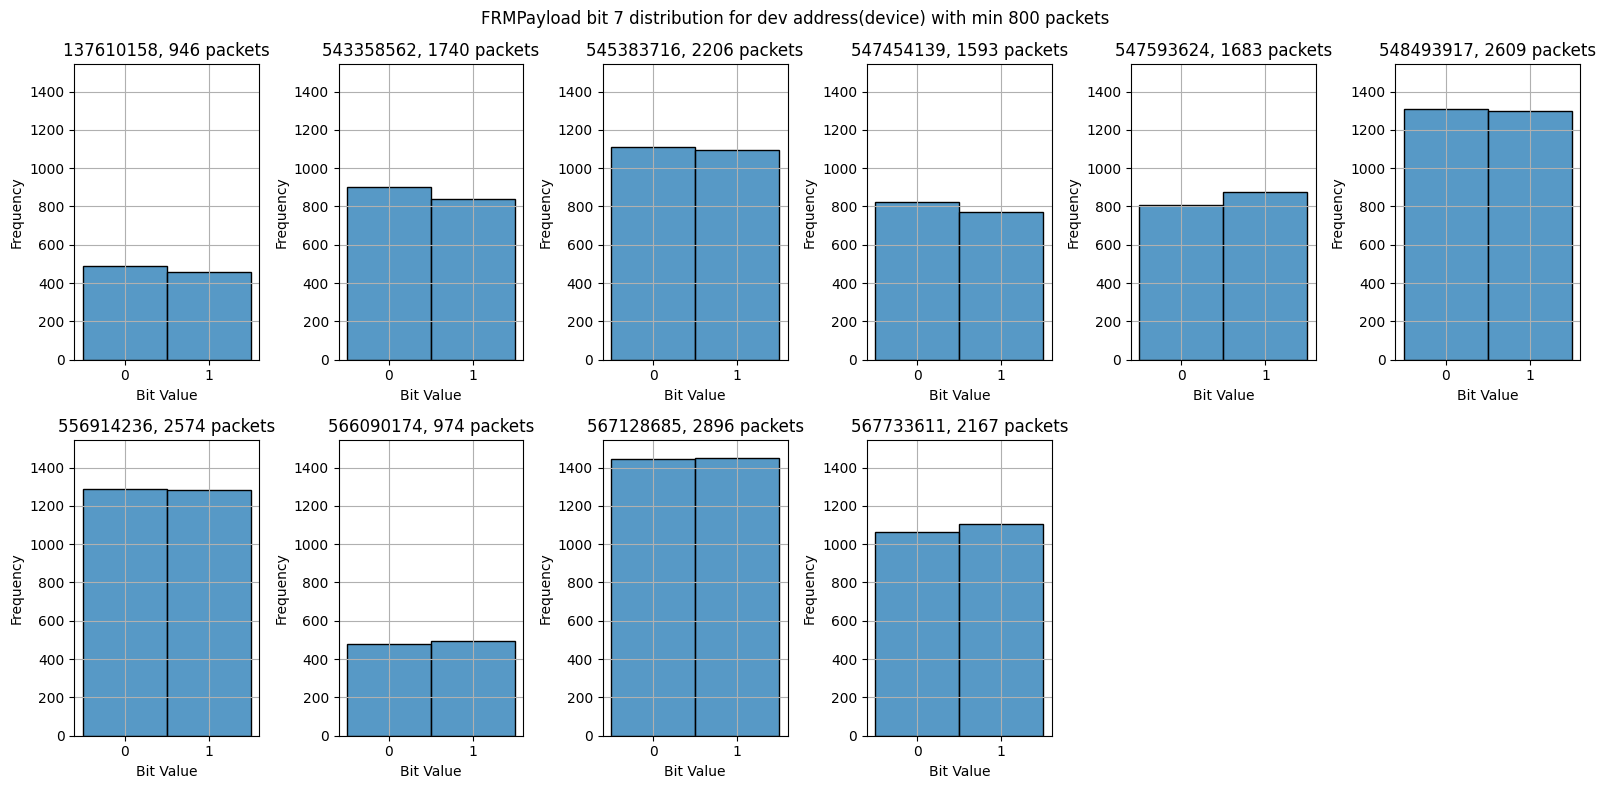

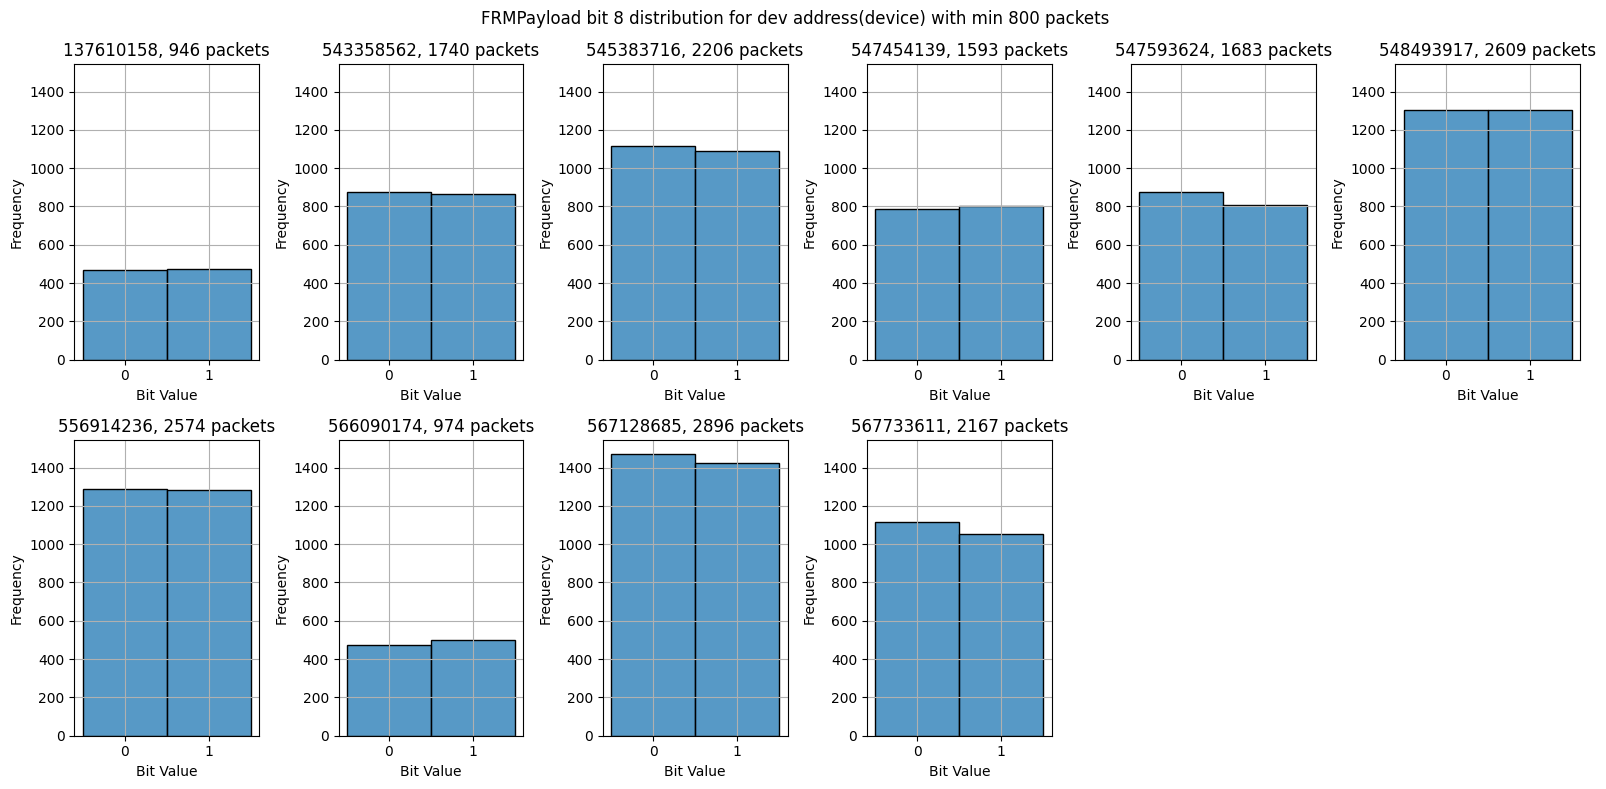

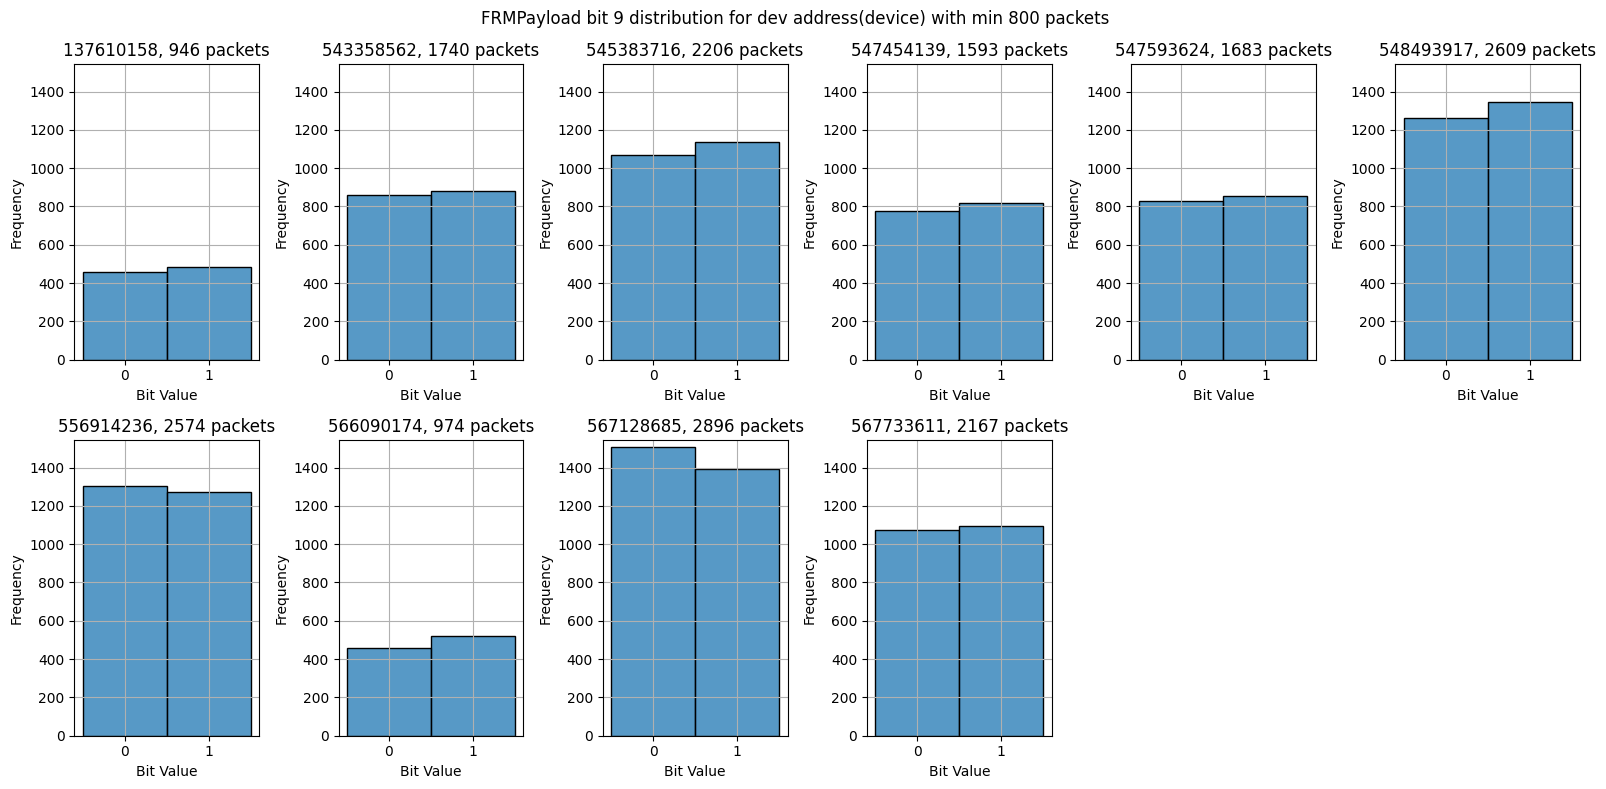

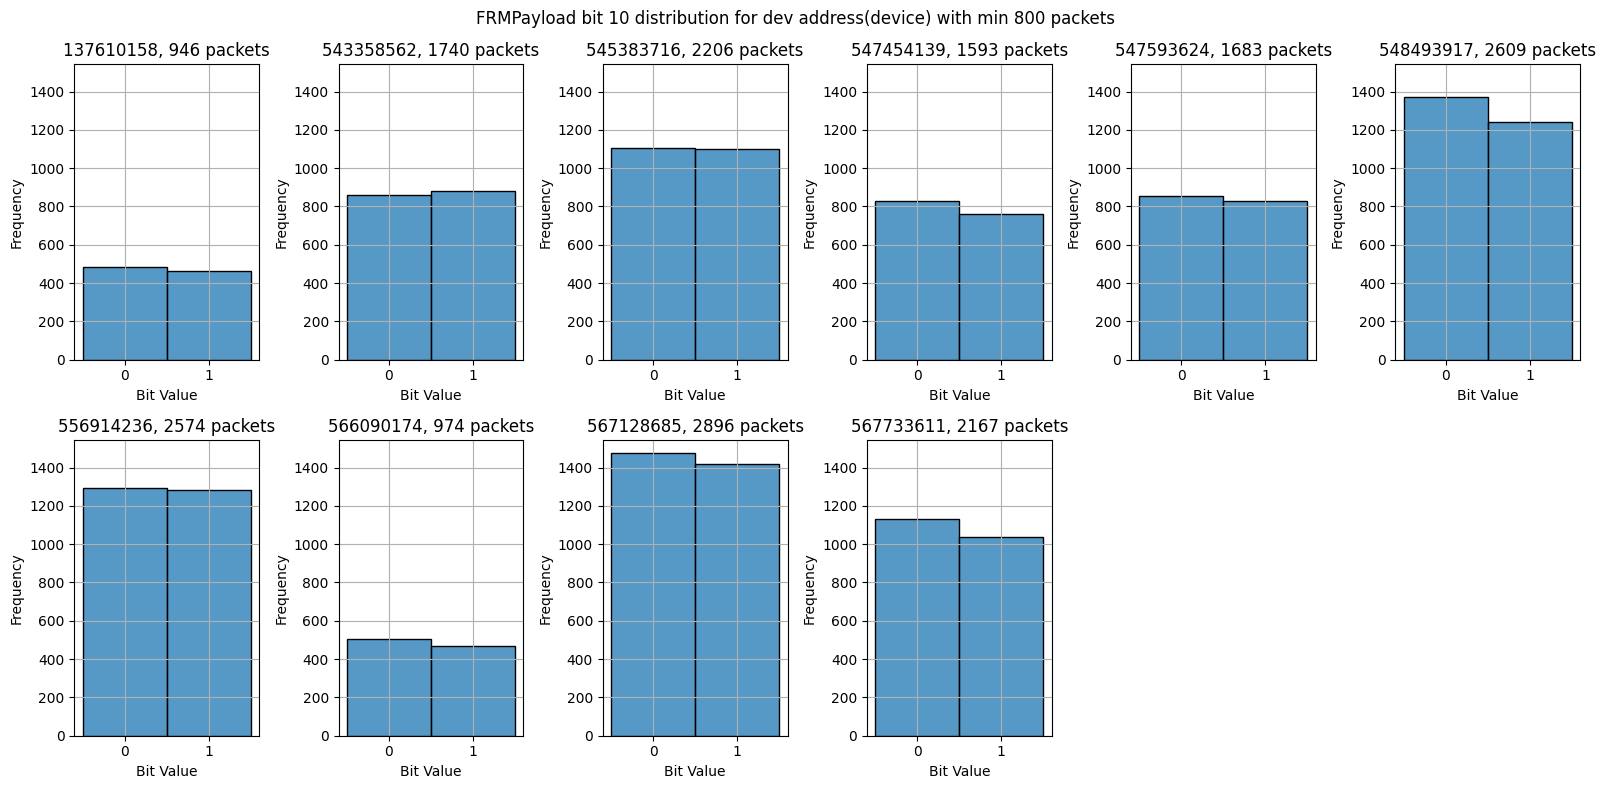

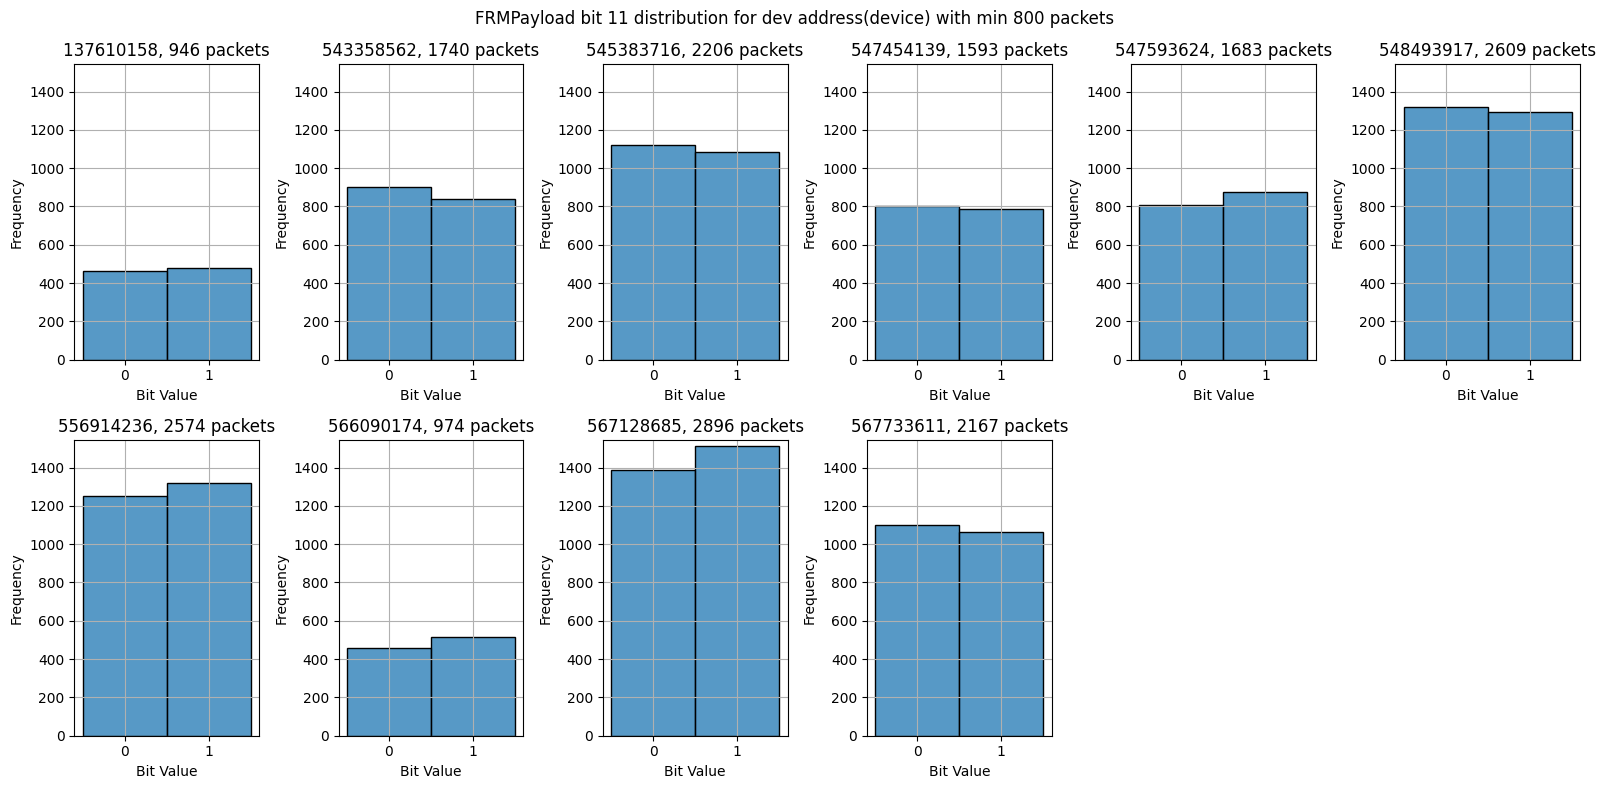

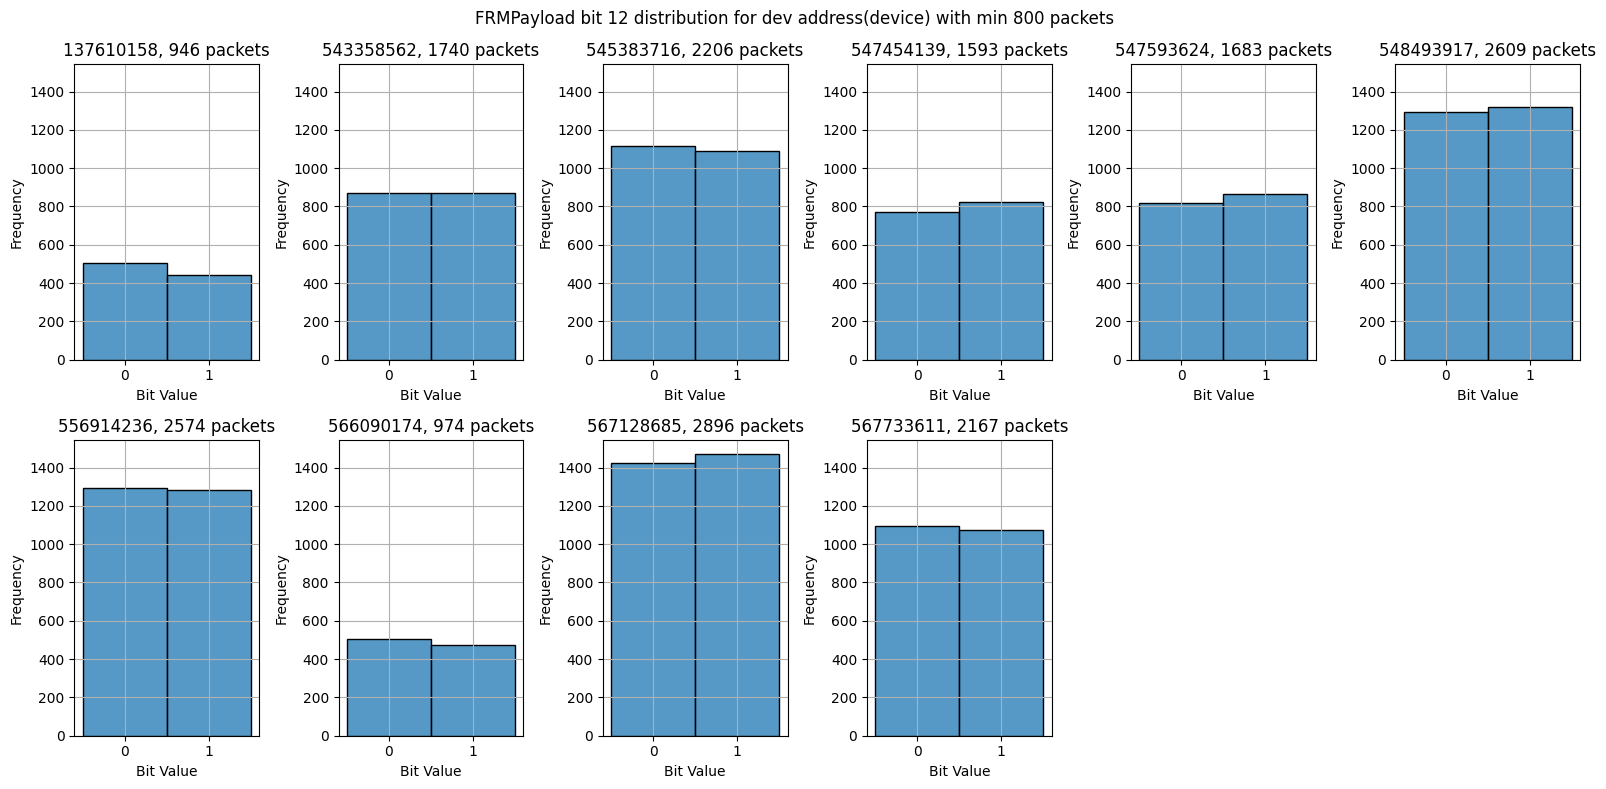

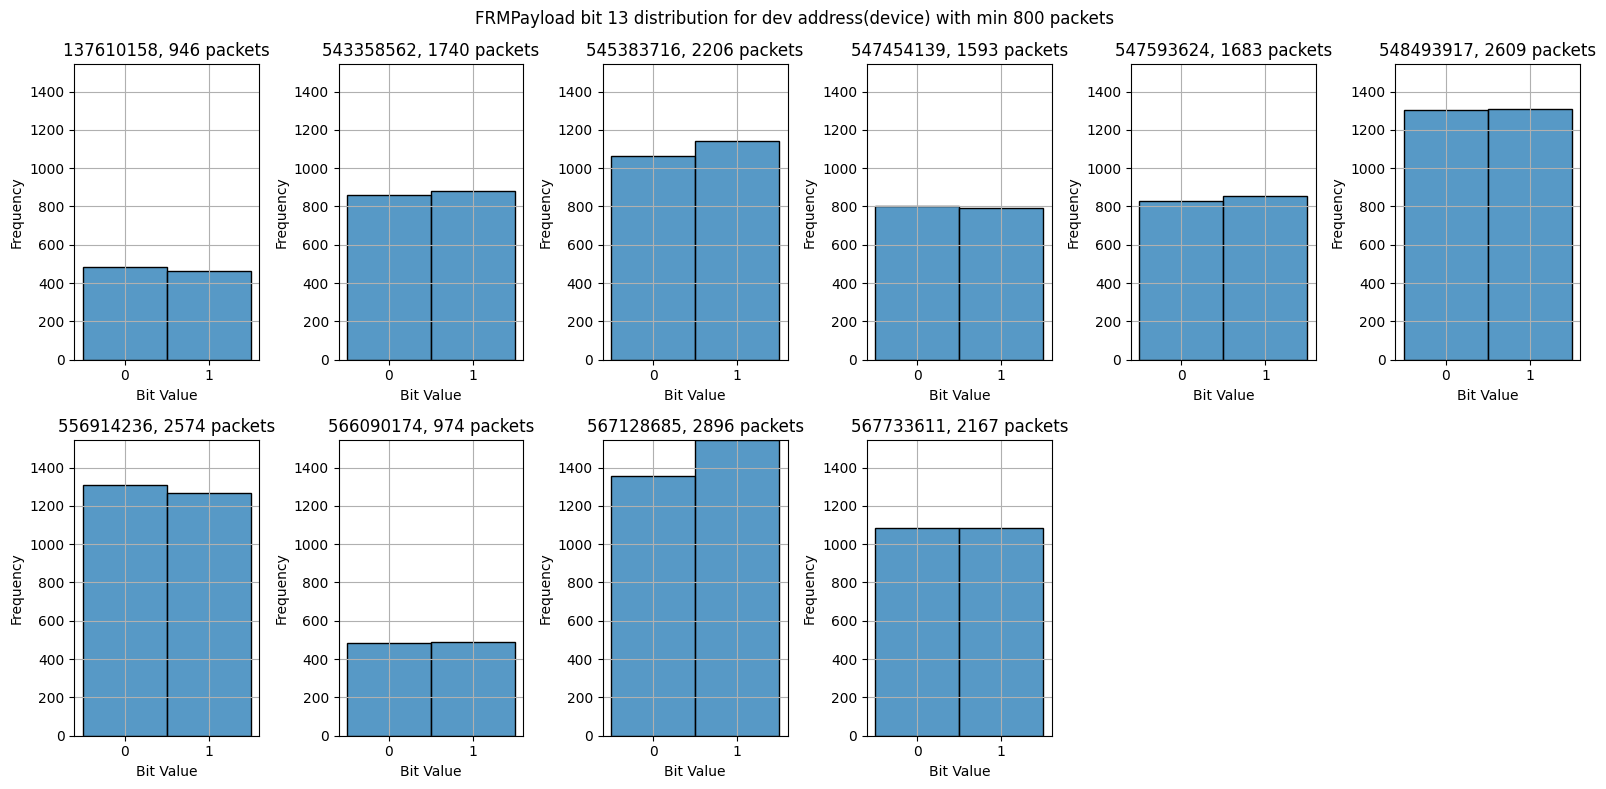

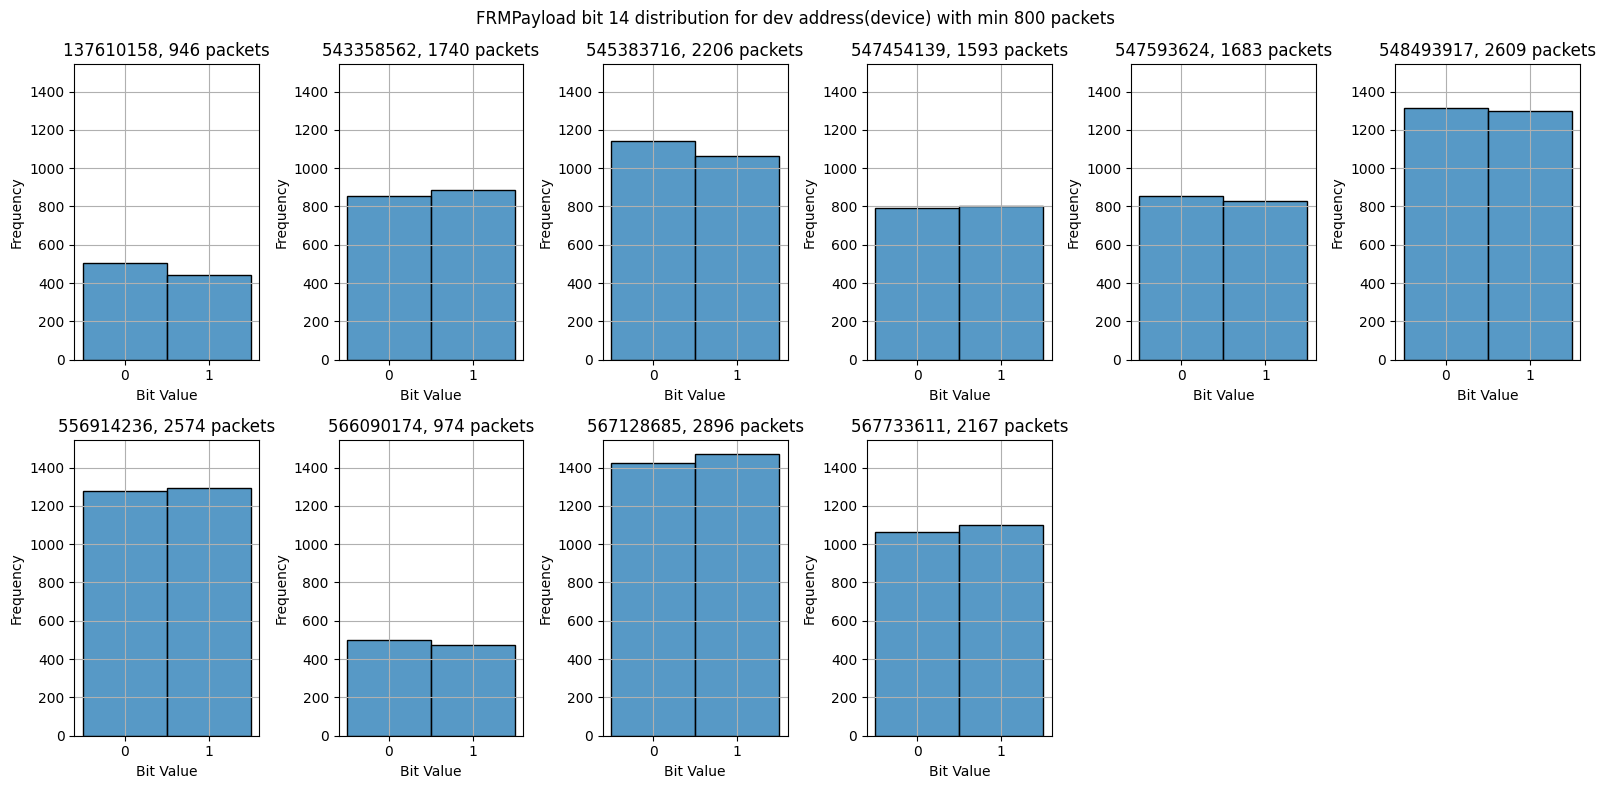

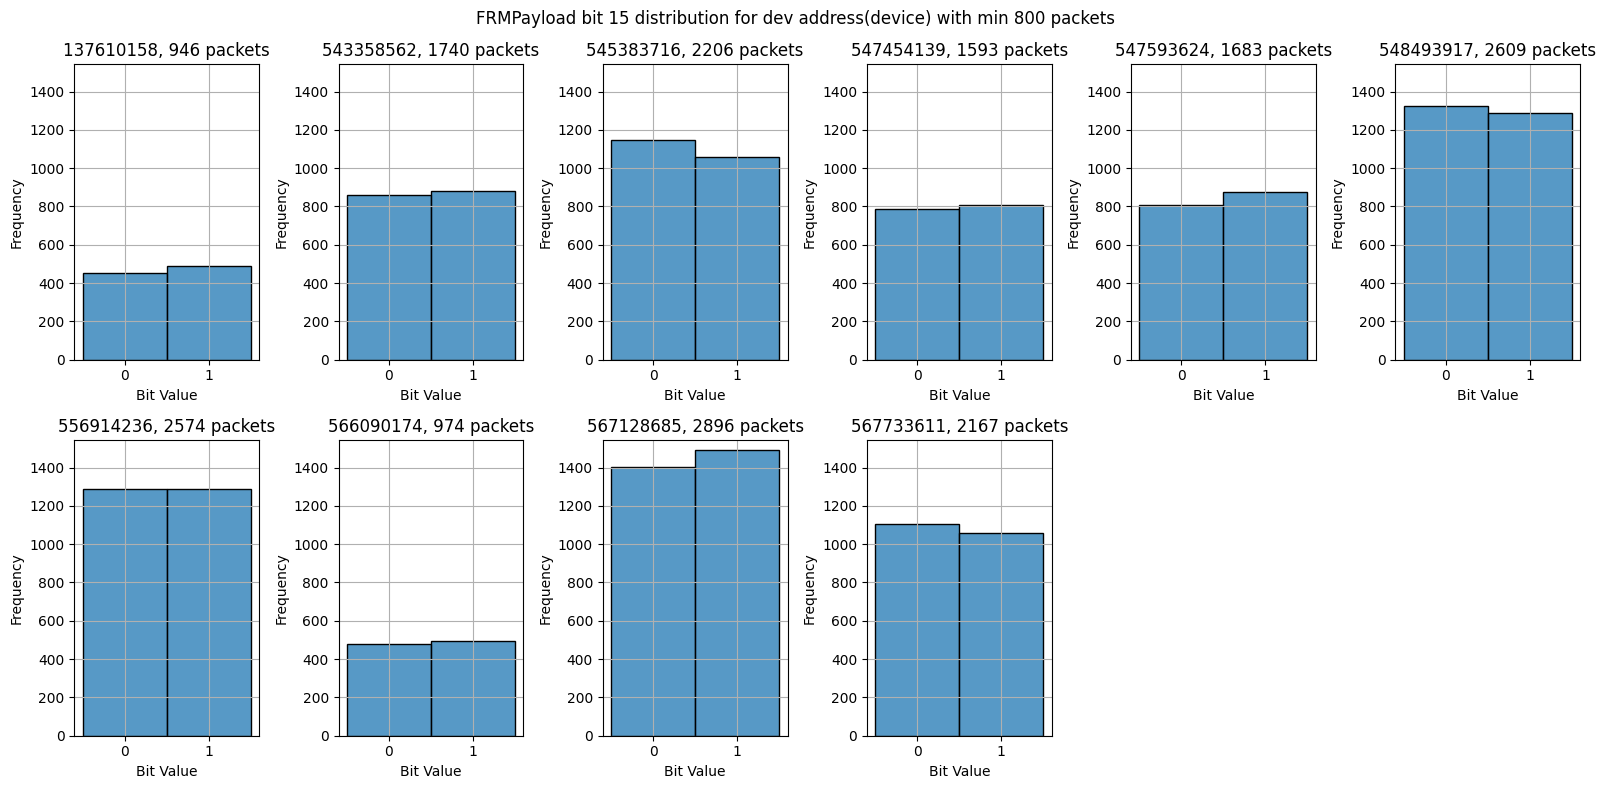

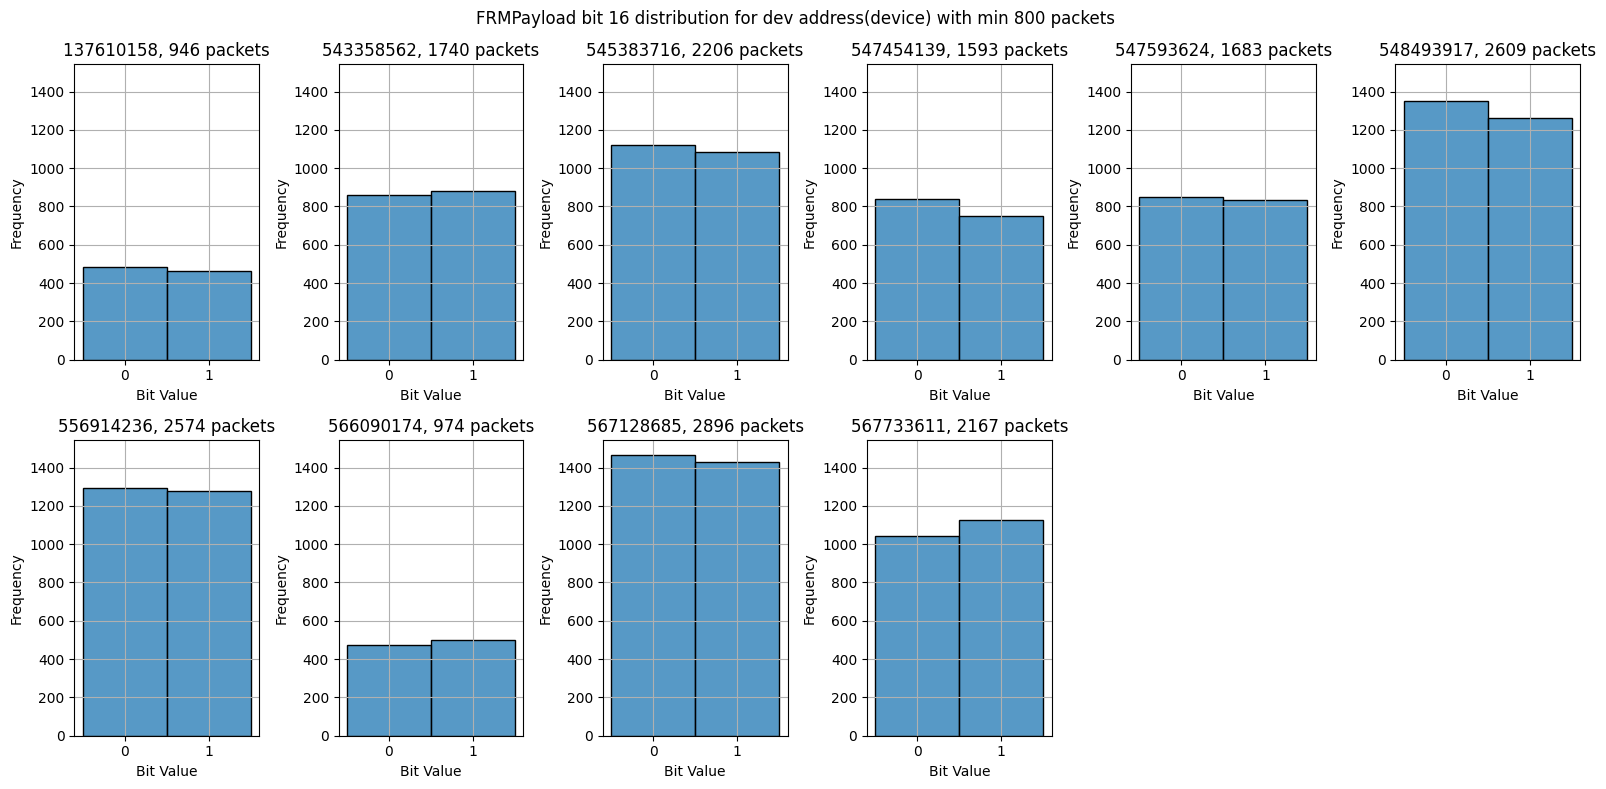

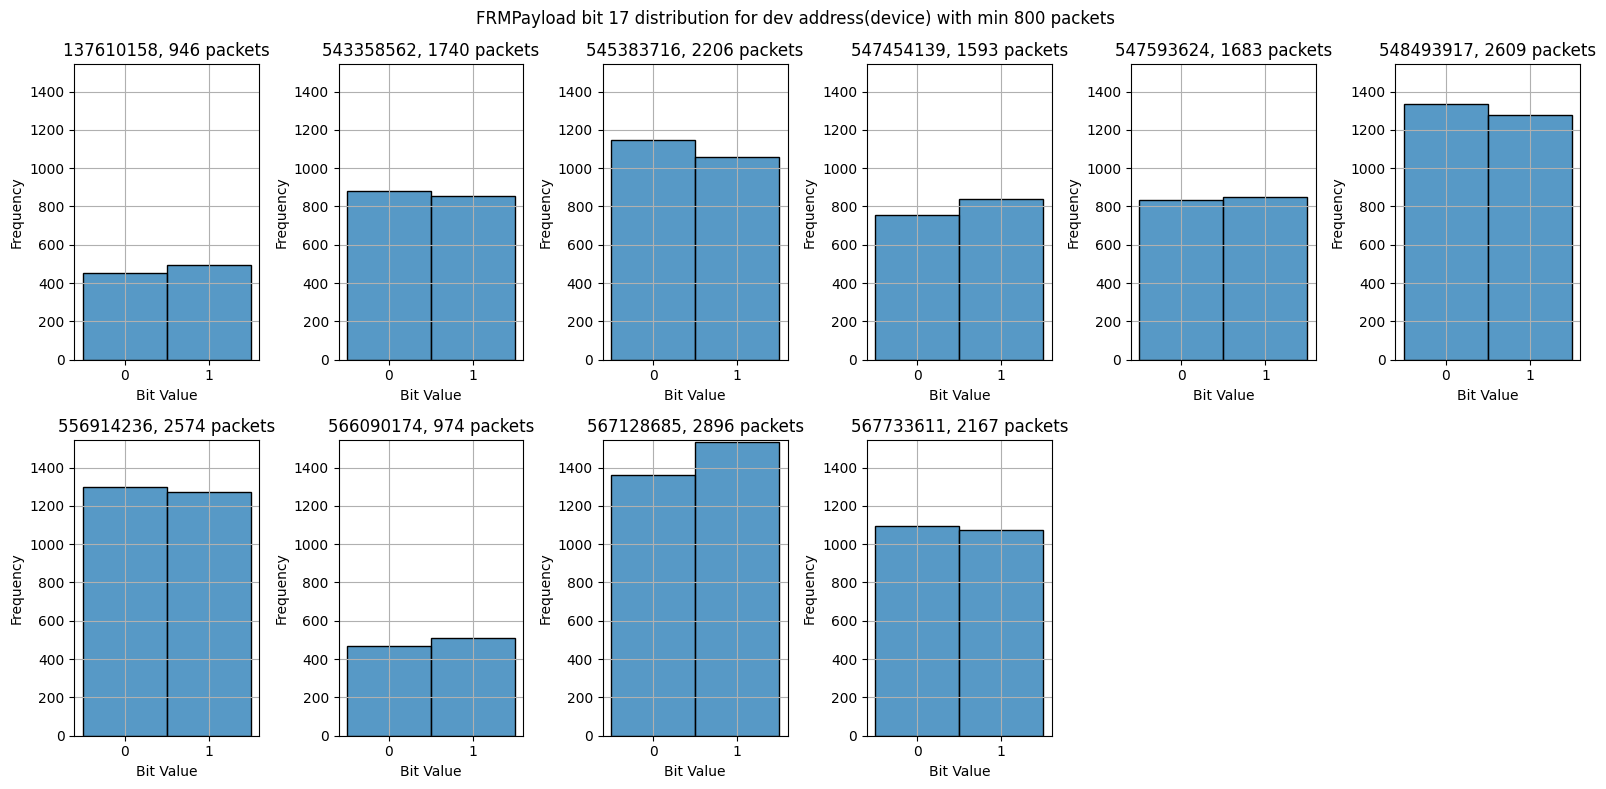

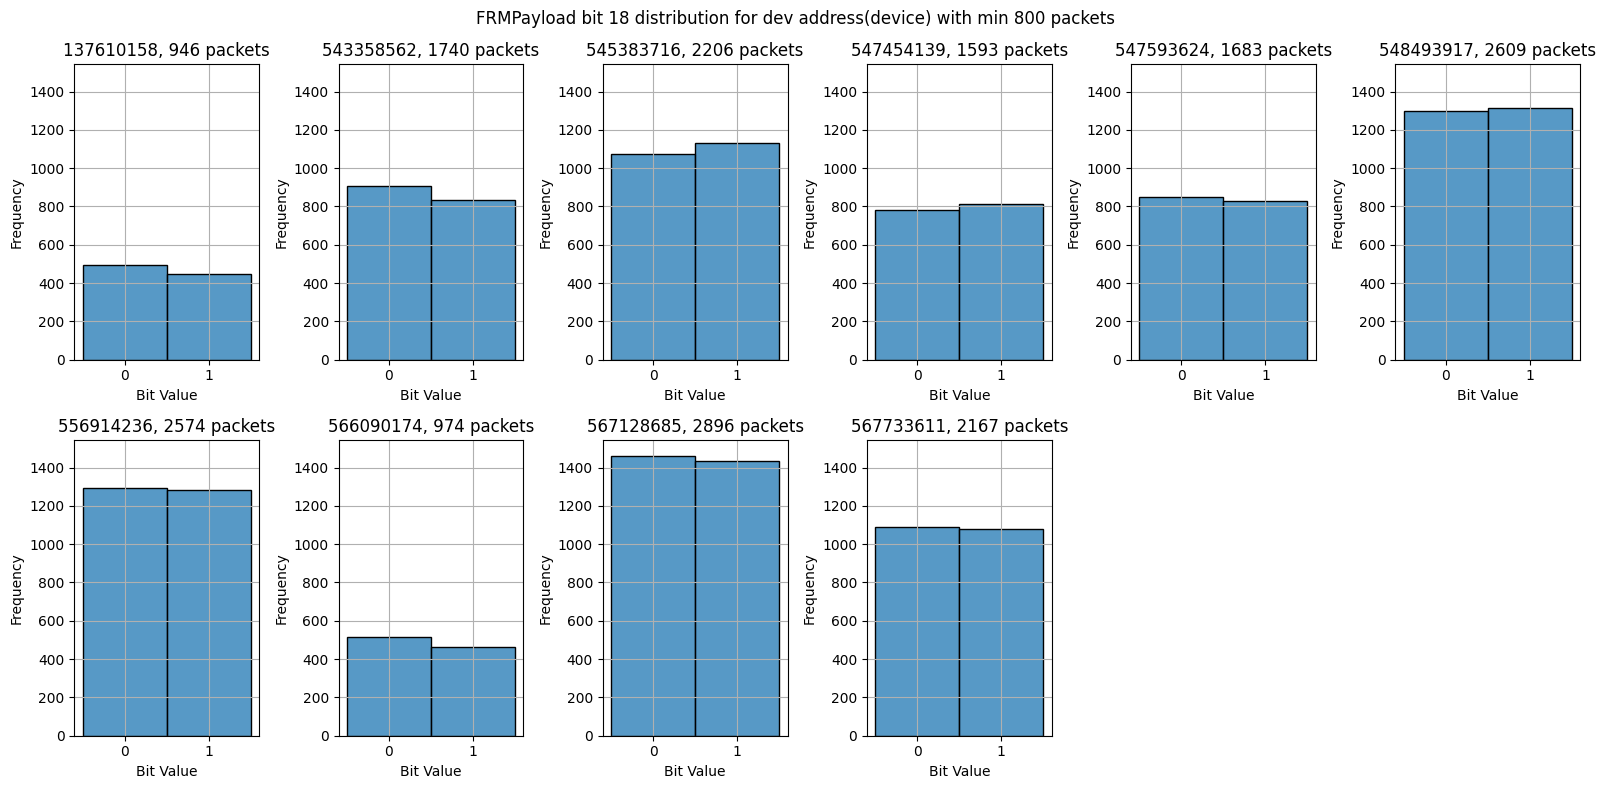

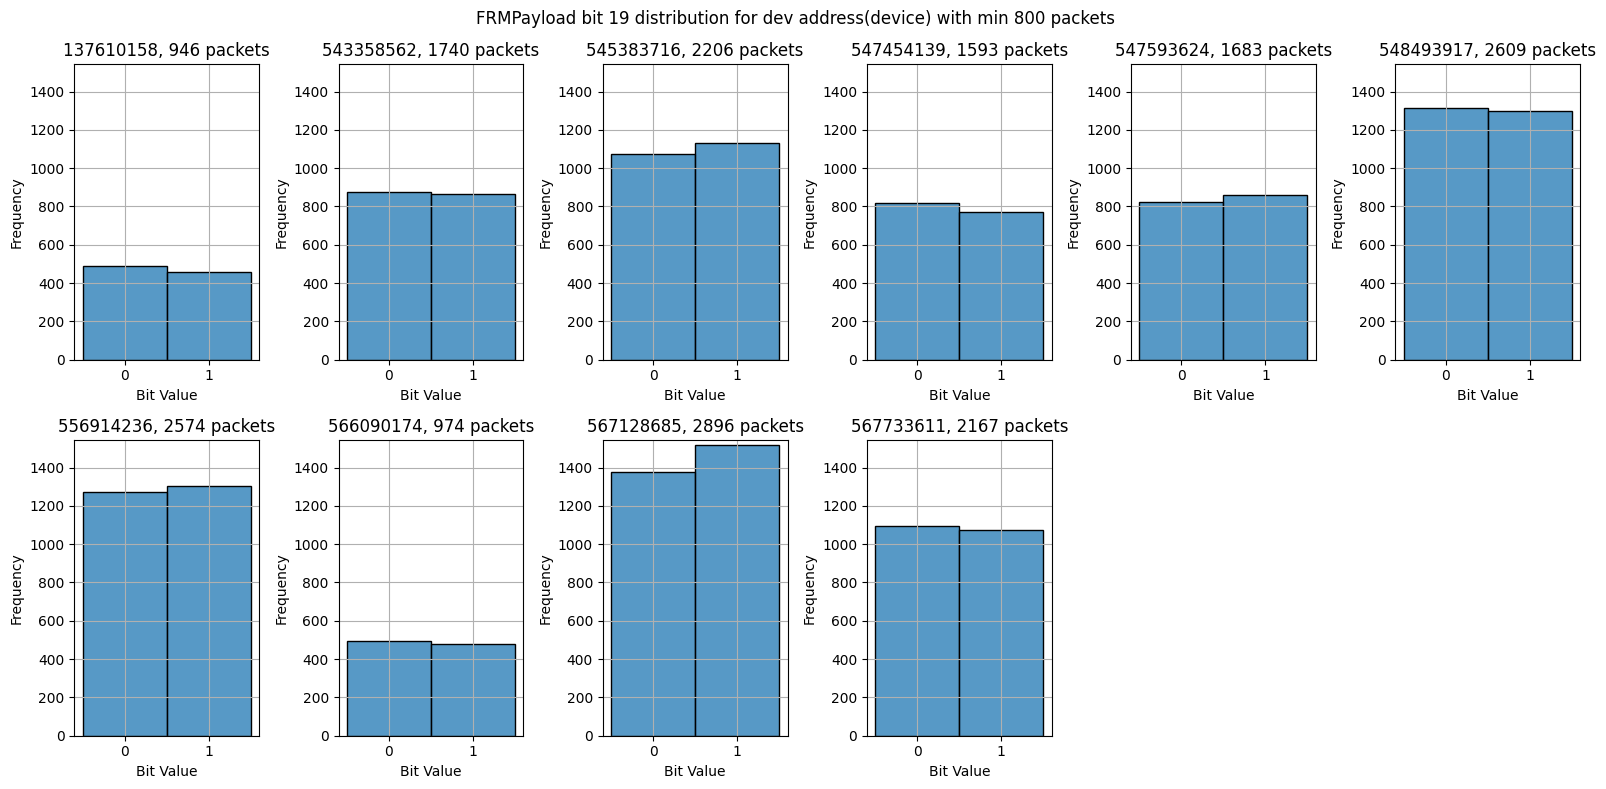

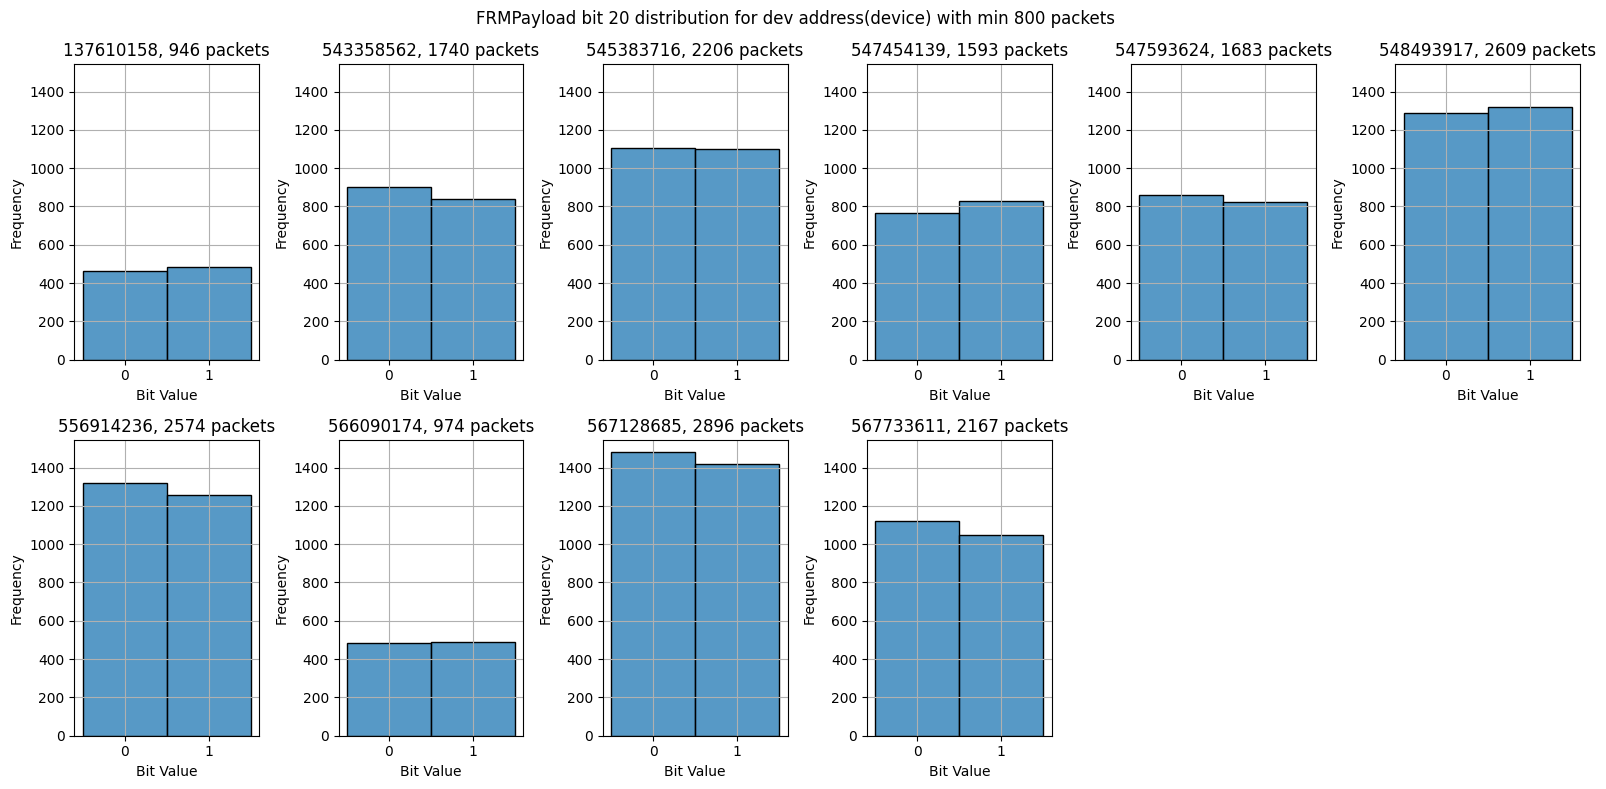

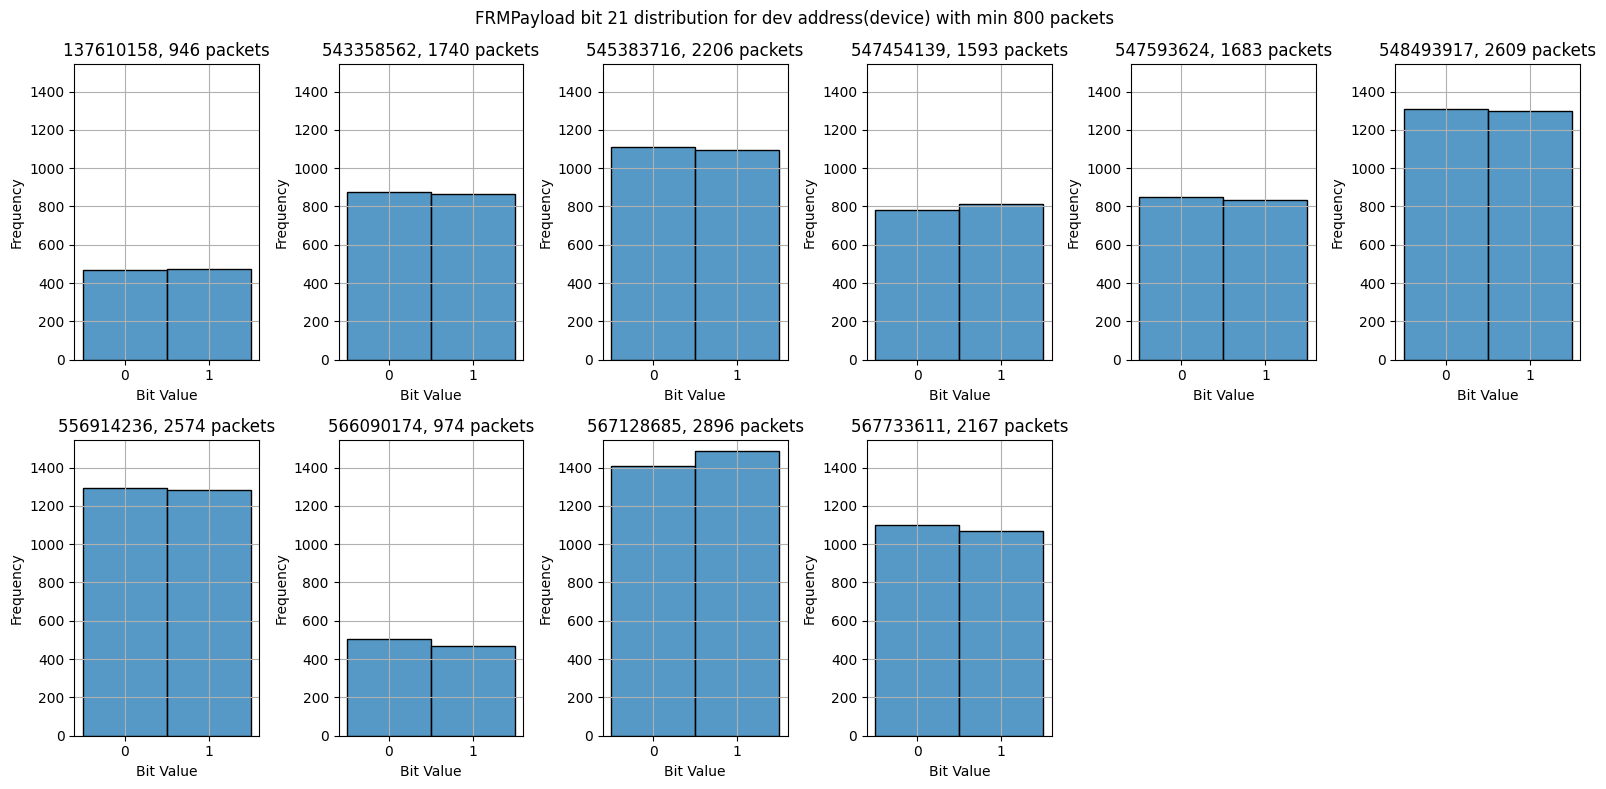

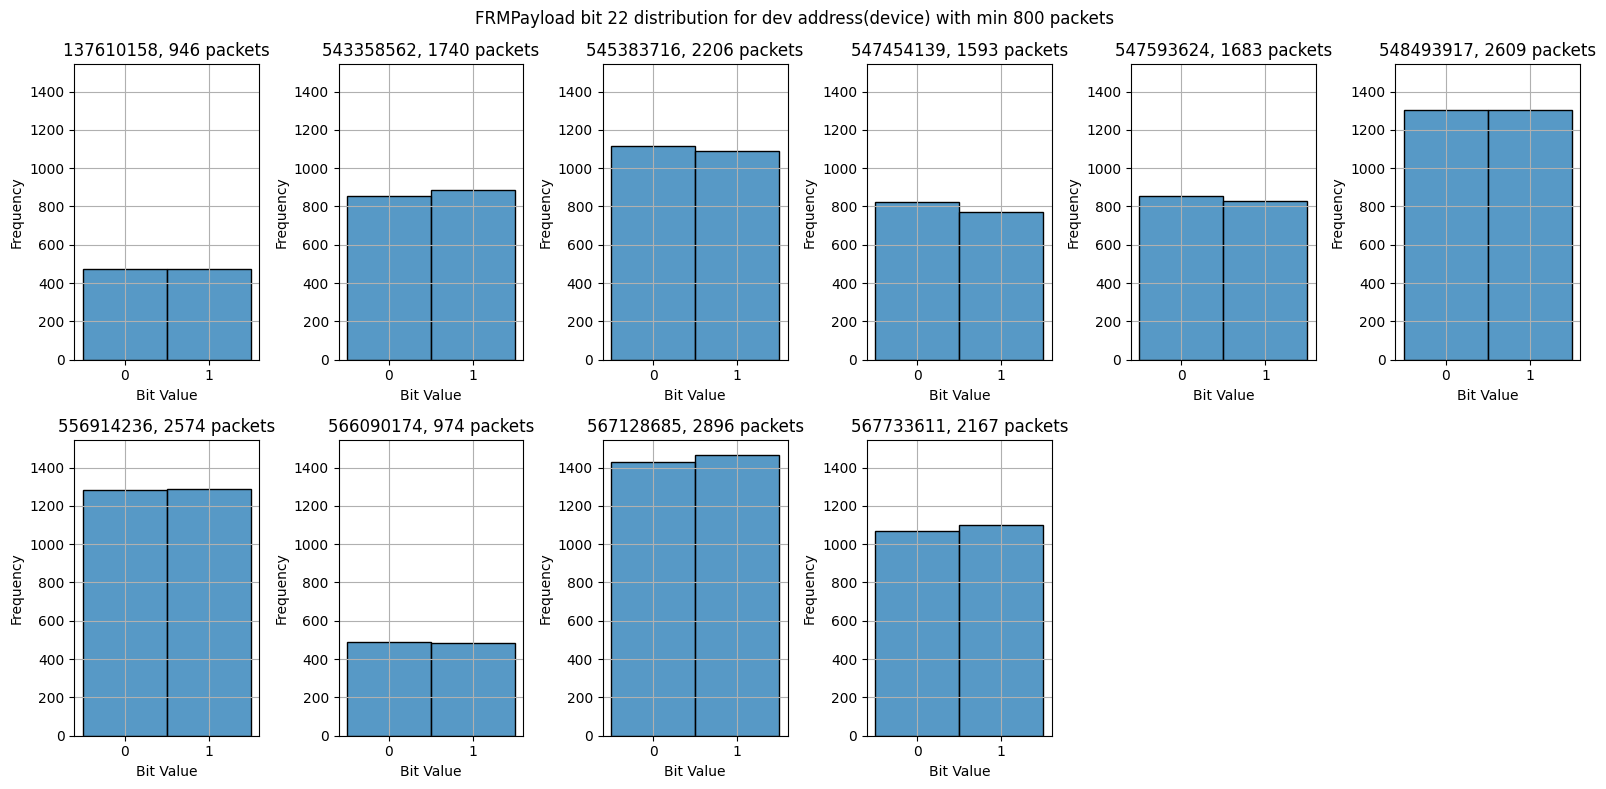

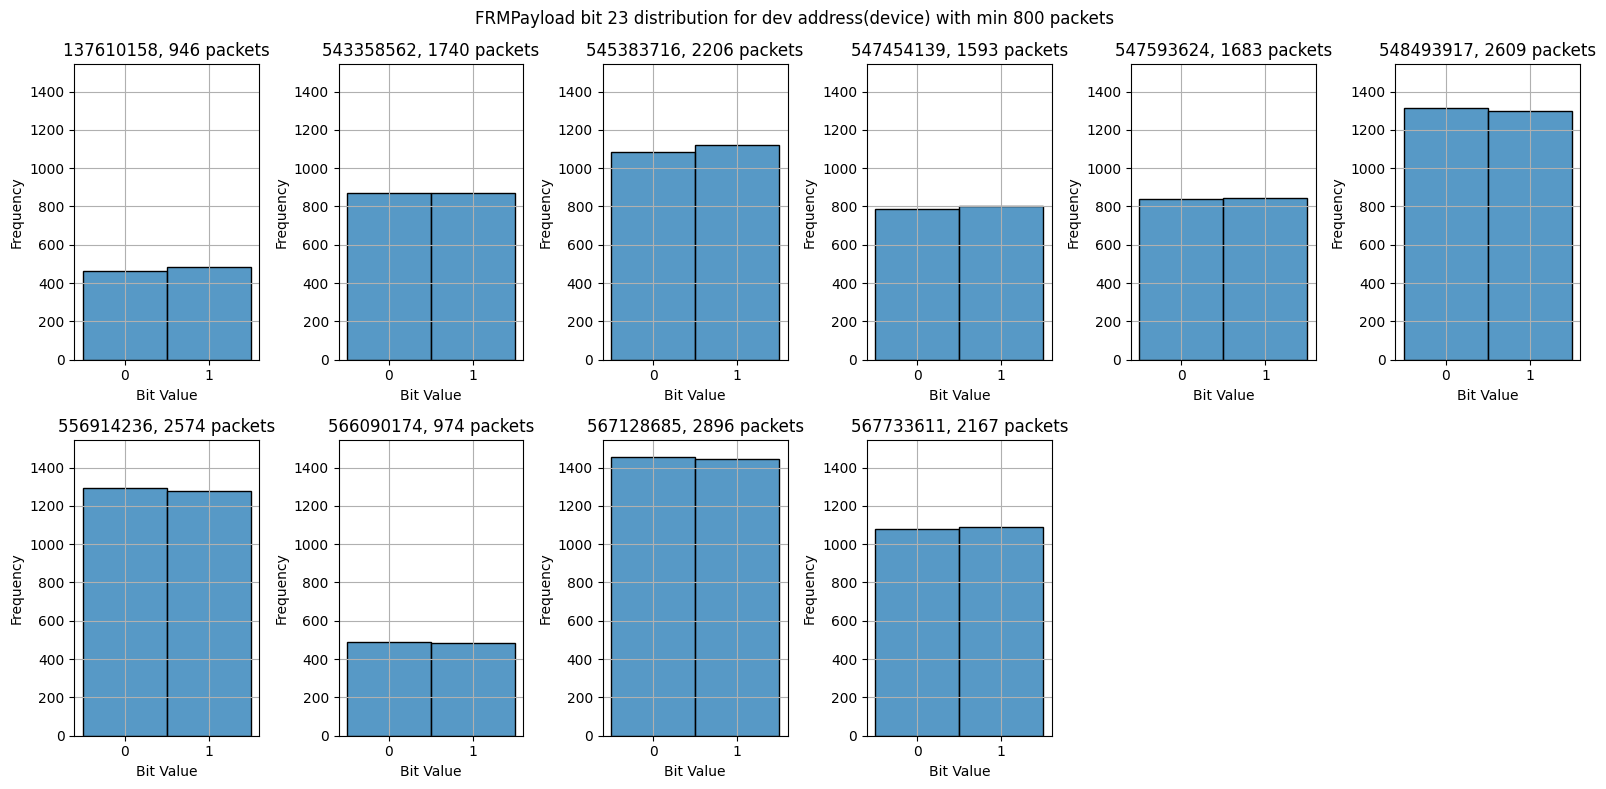

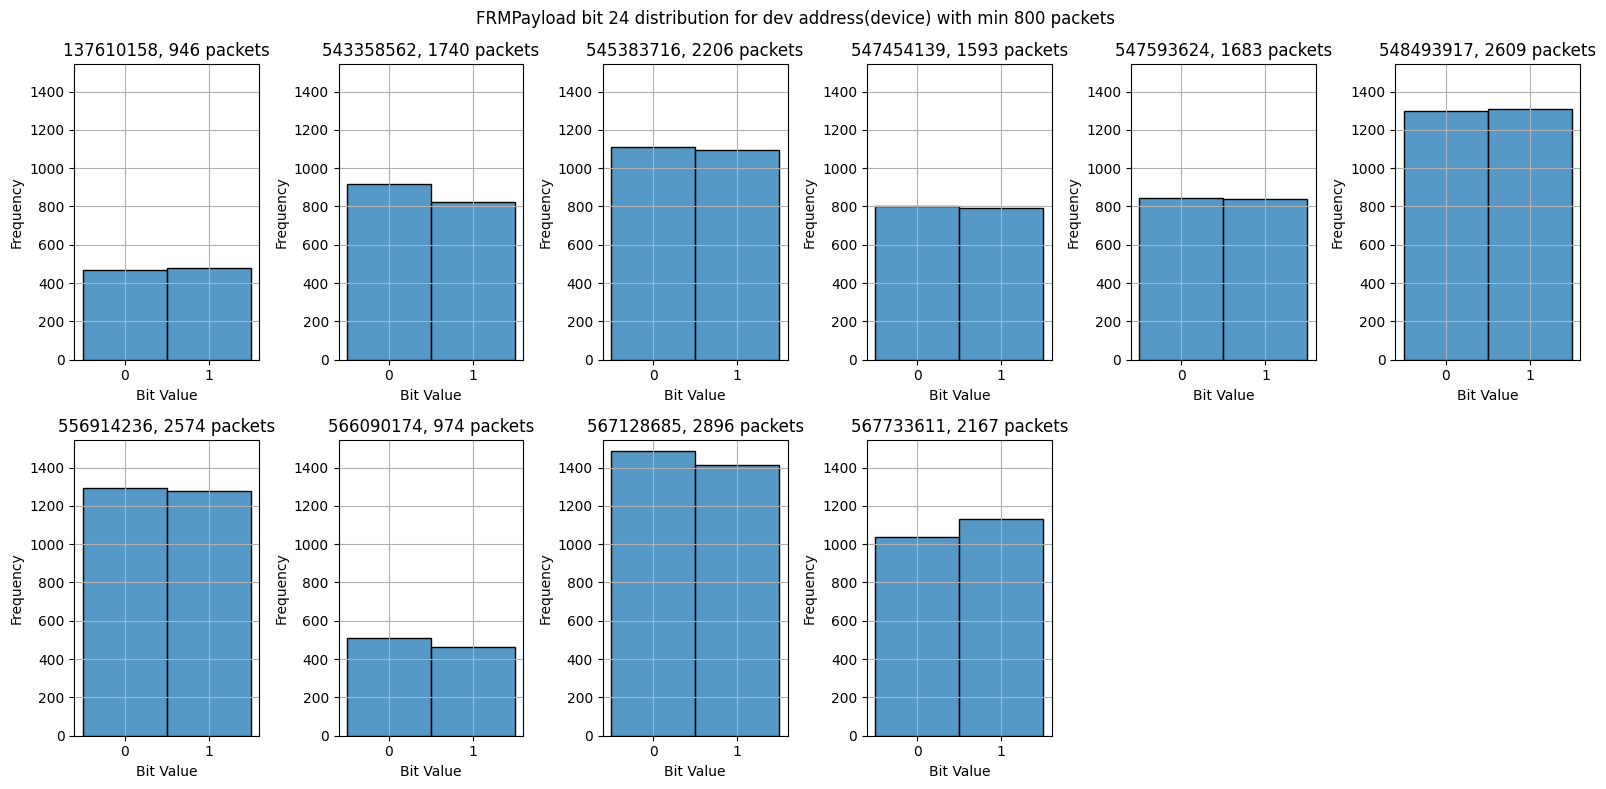

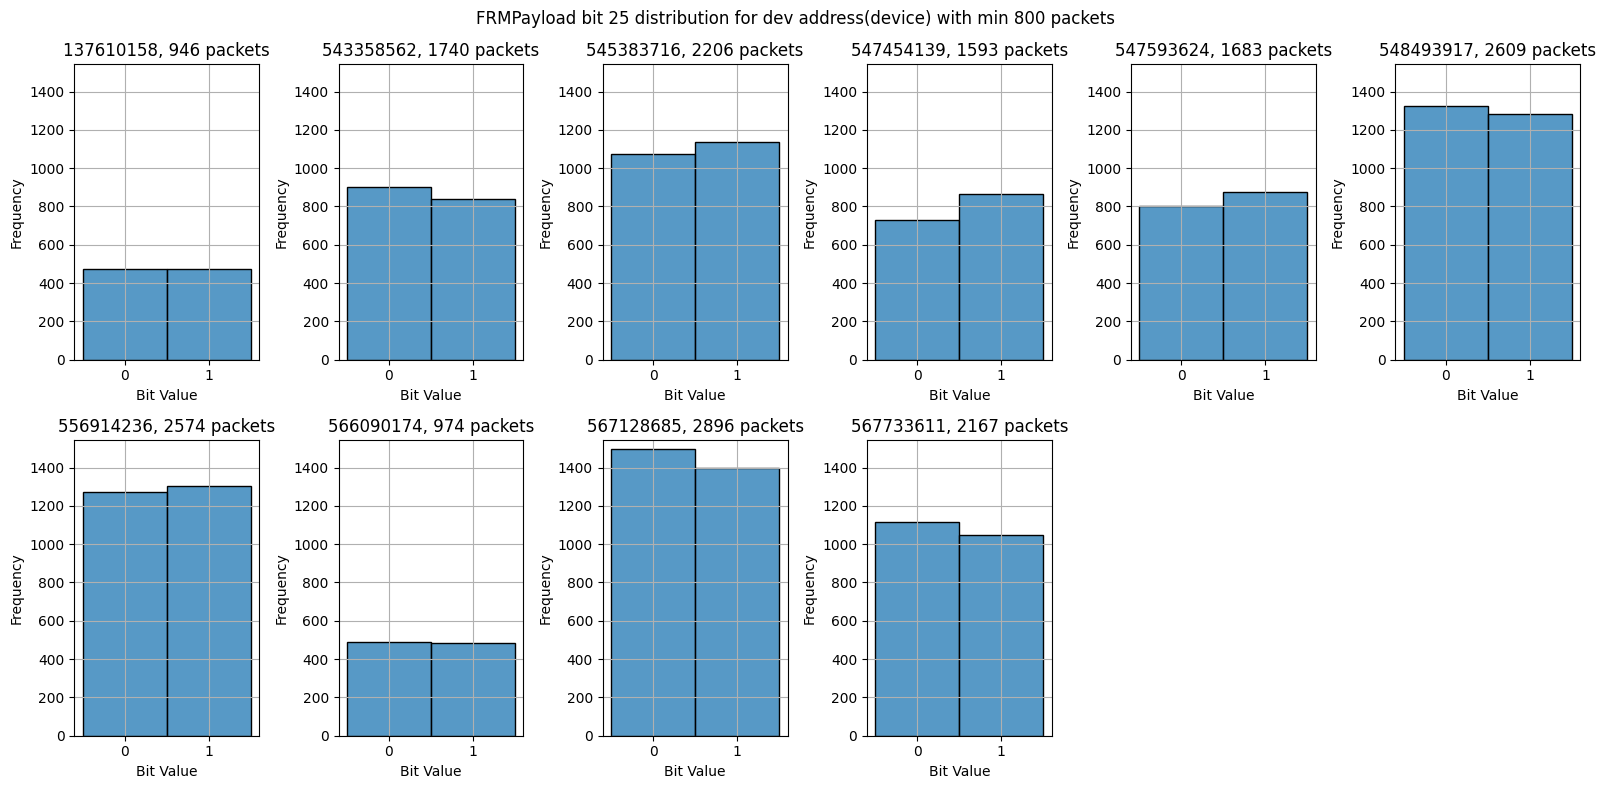

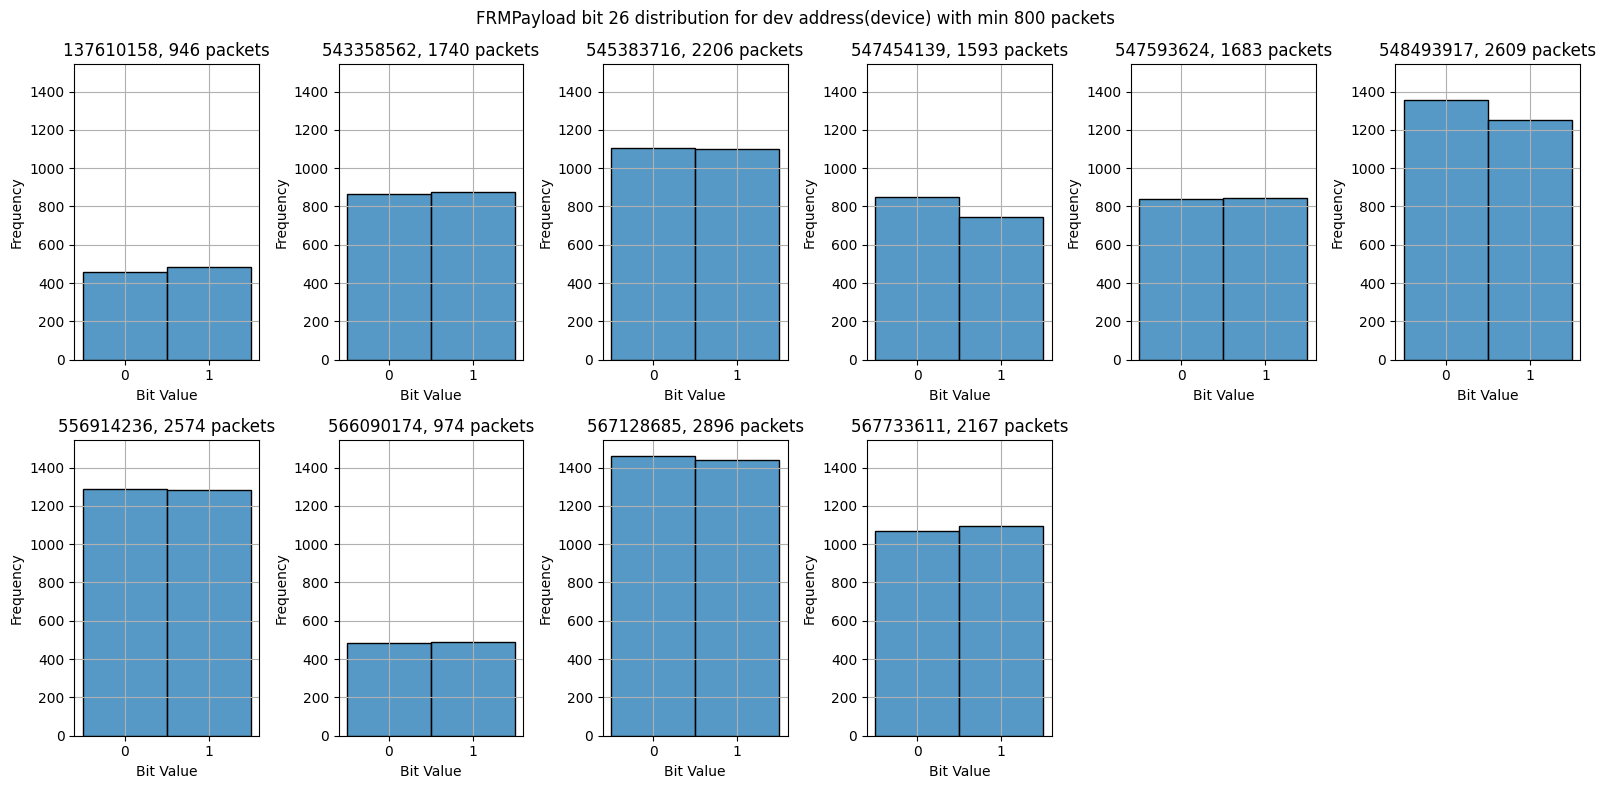

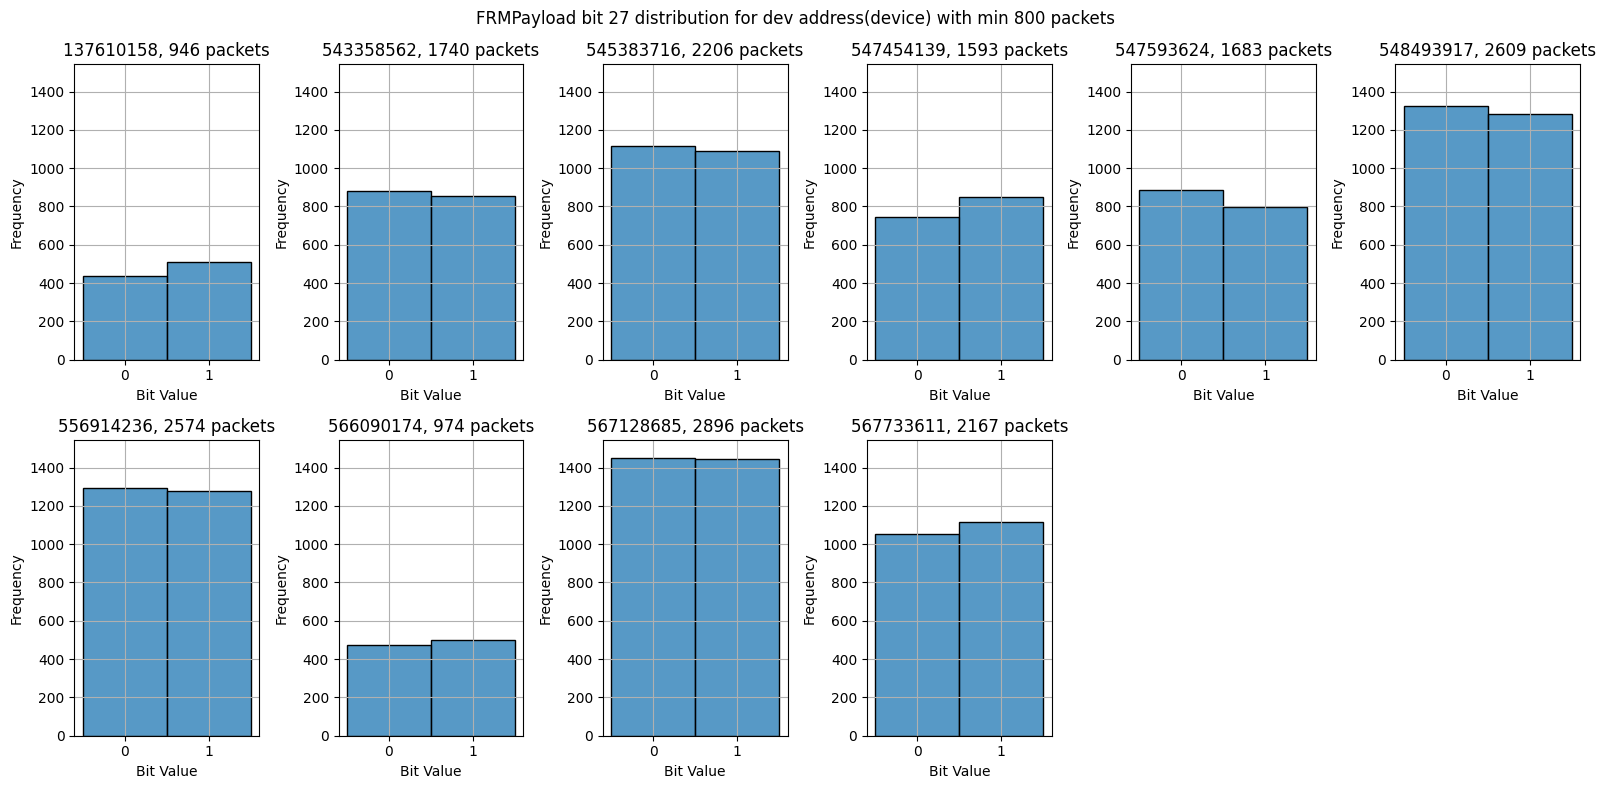

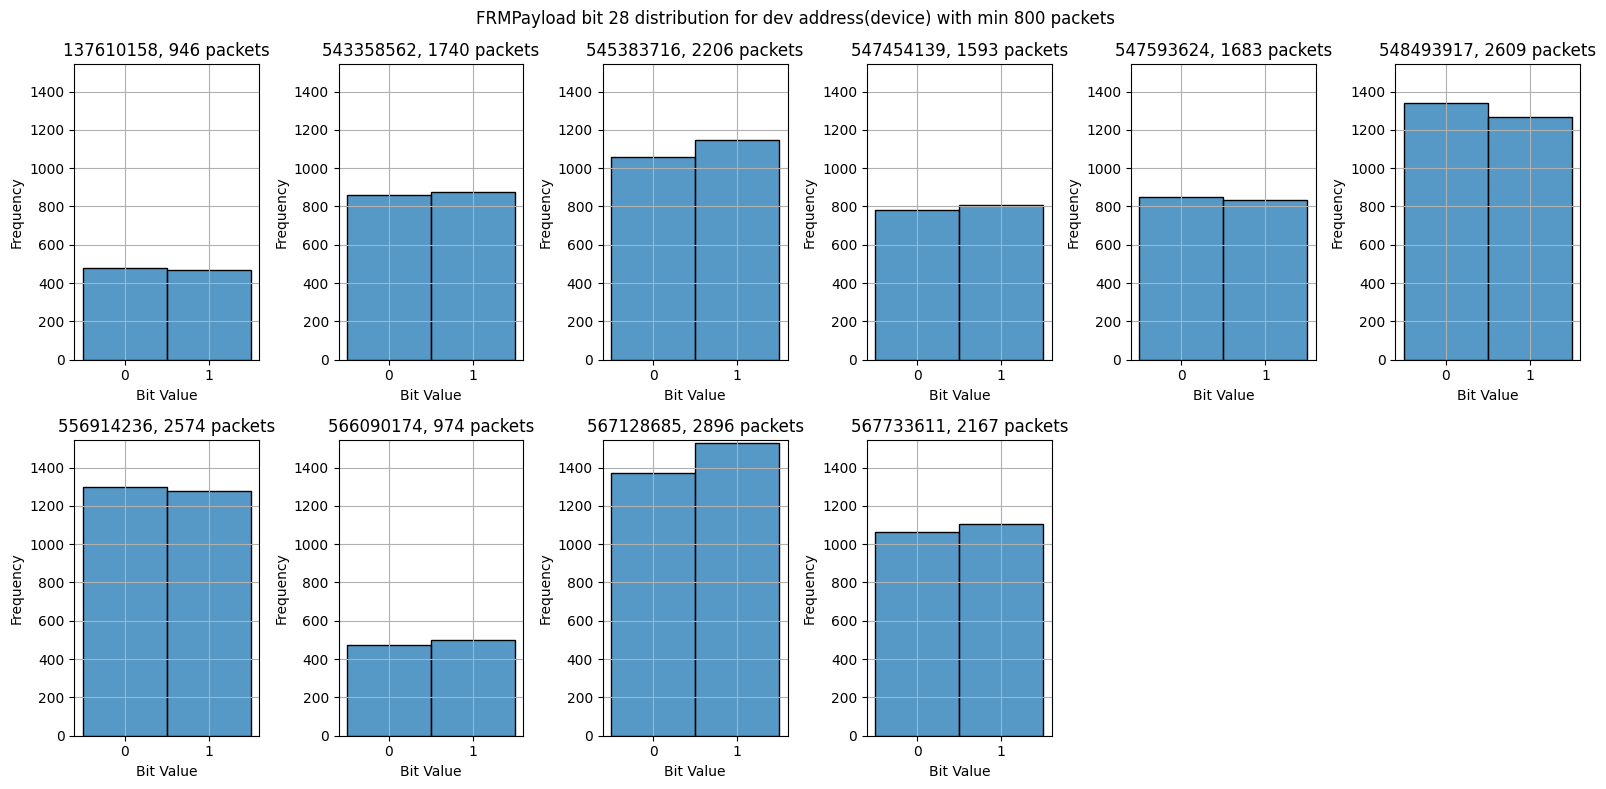

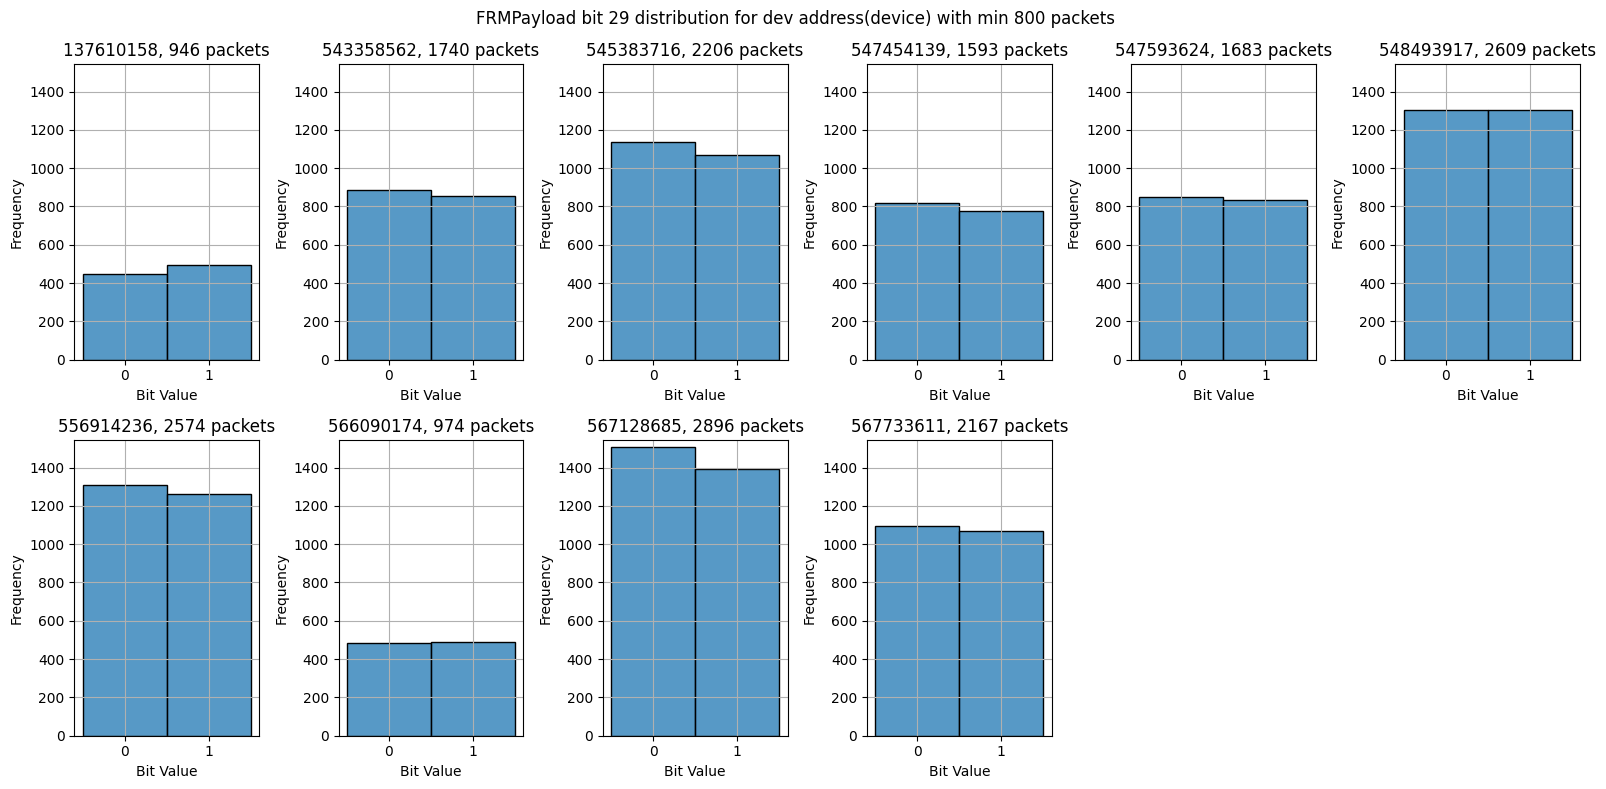

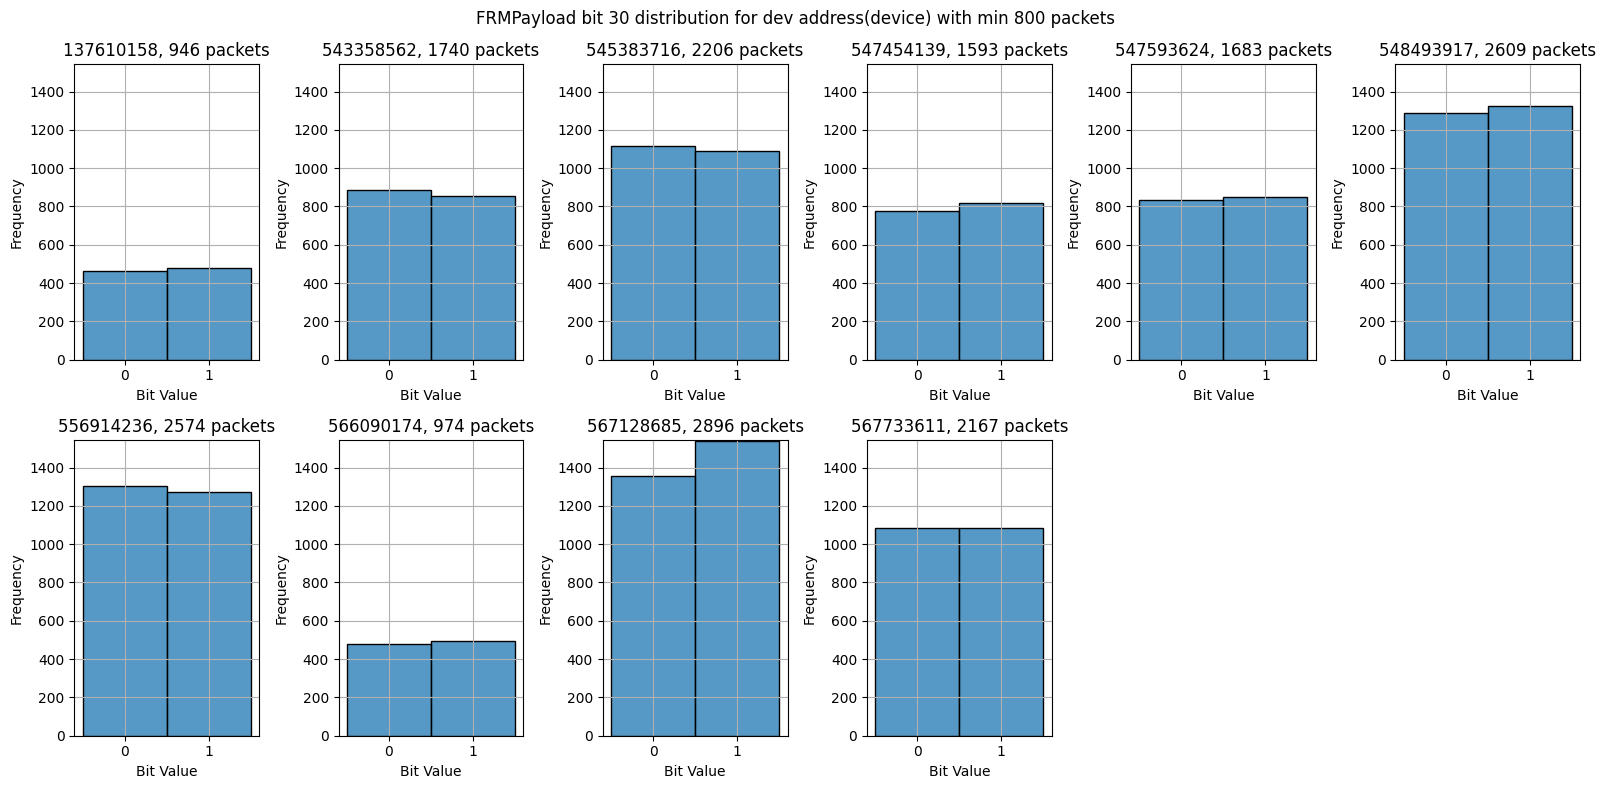

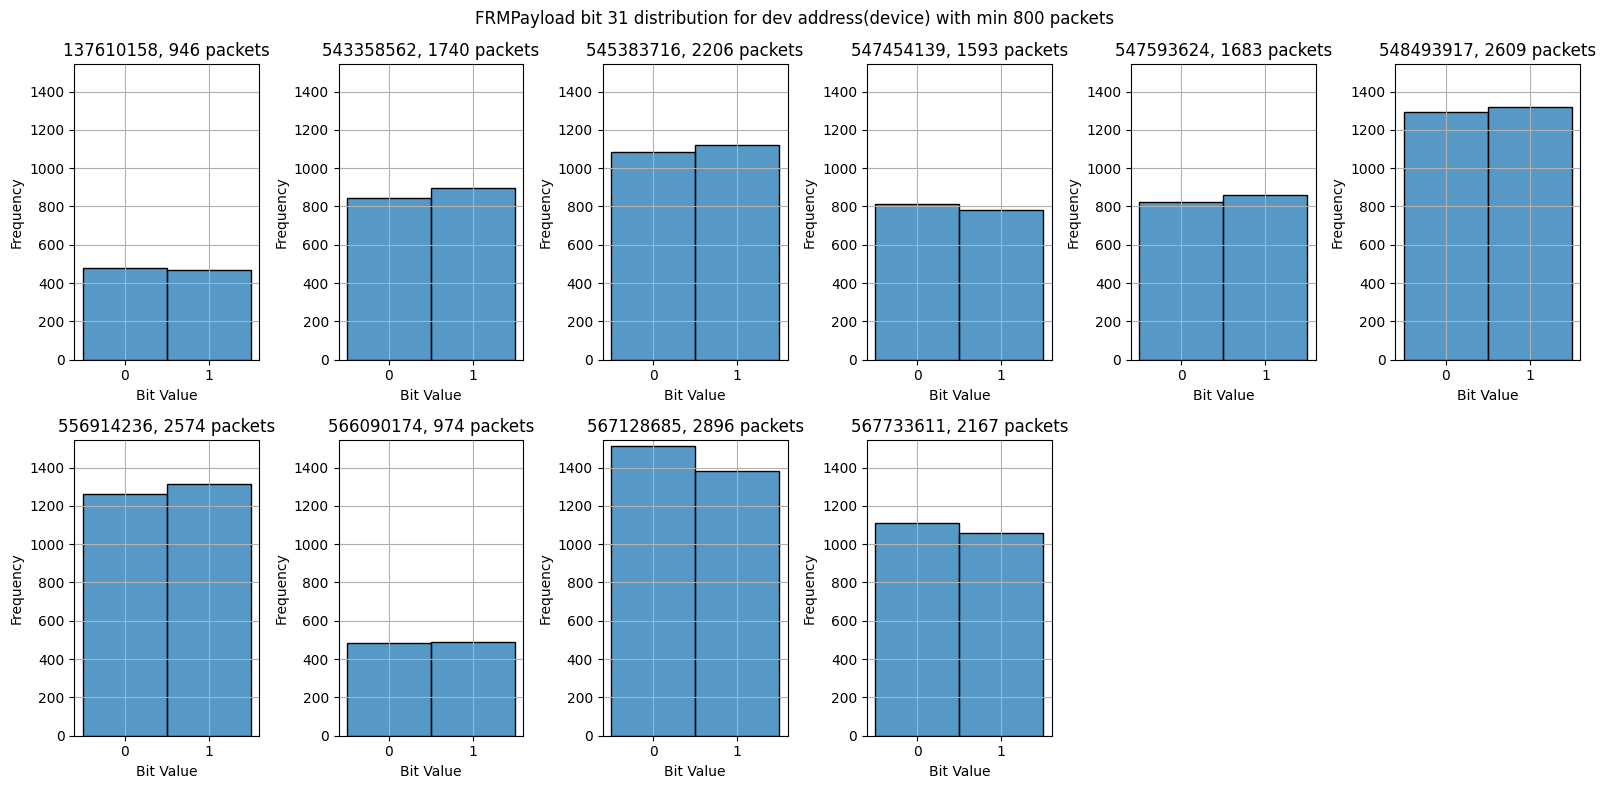

' mic_filtered_data = extract_and_filter_data(file_path, Field.MIC, min_messages)\nmax_frequency = compute_max_frequency(mic_filtered_data)\nplot_bit_distribution(mic_filtered_data, max_frequency, num_cols, min_messages, "MIC")\n '

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

def extract_and_filter_data(file_path, field, min_messages):
    data_by_dev_addr = extract_for_all_devaddr(file_path, field.value)
    return {devaddress: data_list for devaddress, data_list in data_by_dev_addr.items() if len(data_list) > min_messages}

def extract_bit(value, bit_position):
    return (value >> bit_position) & 1

def compute_max_frequency(filtered_data):
    max_frequency = 0
    for devaddress, data_list in filtered_data.items():
        for bit_computed in range(32):
            bit_0_list = [extract_bit(data, bit_computed) for data in data_list]
            frequency_0 = bit_0_list.count(0)
            frequency_1 = bit_0_list.count(1)
            max_frequency = max(max_frequency, frequency_0, frequency_1)
    return max_frequency

def plot_distribution(subplot, data, label, max_frequency):
    sns.histplot(data, kde=False, discrete=True, ax=subplot)
    subplot.set_ylim(0, max_frequency)
    subplot.set_title(label)
    subplot.set_xlabel('Bit Value')
    subplot.set_ylabel('Frequency')
    subplot.set_xticks([0, 1])
    subplot.grid(True)

def plot_bit_distribution(filtered_data, max_frequency, num_cols, min_messages, data_type):
    num_devaddresses = len(filtered_data)
    for bit_computed in range(32):
        num_rows = -(-num_devaddresses // num_cols)
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 4))
        axes = axes.flatten()
        fig.suptitle(f'{data_type} bit {bit_computed} distribution for dev address(device) with min {min_messages} packets')

        for idx, (devaddress, data_list) in enumerate(filtered_data.items()):
            bit_0_list = [extract_bit(data, bit_computed) for data in data_list]
            plot_distribution(axes[idx], bit_0_list, f"{devaddress}, {len(data_list)} packets", max_frequency)
        
        for i in range(len(filtered_data), len(axes)):
            fig.delaxes(axes[i])
            
        plt.tight_layout(rect=[0, 0, 1, 1])
        plt.show()

file_path = './test_bit_quality/wss_messages.json'
min_messages = 800
num_cols = 6

frmpayload_filtered_data = extract_and_filter_data(file_path, Field.FRMPayload, min_messages)
max_frequency = compute_max_frequency(frmpayload_filtered_data)
plot_bit_distribution(frmpayload_filtered_data, max_frequency, num_cols, min_messages, "FRMPayload")

mic_filtered_data = extract_and_filter_data(file_path, Field.MIC, min_messages)
max_frequency = compute_max_frequency(mic_filtered_data)
plot_bit_distribution(mic_filtered_data, max_frequency, num_cols, min_messages, "MIC")


# Verify bit entropy

The aim is to generate a crypo random number that should be uniformaly distributed. This will help to selected random bits set to 1 in the collected MICs.
The AND between the CSPRNG generated number and the MIC will keep the bits set to 1. After counting this, it should be a result even or odd and the aim is to repeat this step multiple times on a big set of MIC using the same CSPRNG to evaluate the quality of bit. A good quality result of an average 50% chance even/odd bits set to 1.

In [65]:
# https://docs.python.org/3/library/secrets.html
import secrets # crypto compliant seed generator

# count the bit set to 1
# src: Maxime Augier
def count_bits(n):
    n = (n & 0x55555555) + ((n & 0xAAAAAAAA) >> 1)
    n = (n & 0x33333333) + ((n & 0xCCCCCCCC) >> 2)
    n = (n & 0x0F0F0F0F) + ((n & 0xF0F0F0F0) >> 4)
    n = (n & 0x00FF00FF) + ((n & 0xFF00FF00) >> 8)
    n = (n & 0x0000FFFF) + ((n & 0xFFFF0000) >> 16)
    return n

def count_bits_with_parity(n):
    count = count_bits(n)
    parity = count & 1  # 0 if even, 1 if odd
    return count, parity

def test_bit_quality(mac_list, verbose=False, num_tests=100):
    even_counts = []
    odd_counts = []

    all_xor = []
    for _ in range(num_tests):
        # init
        # a crypto safe random, counters
        random_32bit = secrets.randbits(32)
        even_count =0
        odd_count = 0

        if verbose:
            print(f"Random 32-bit : {random_32bit:032b}")
            print(f"-------------------------------------------------------")

        # must be used to detect pattern
        xor_result = 0

        for mac in mac_list:
            if verbose:
                print(f"MAC:            {mac:032b}")
            
            # extract bit set to 1 selected randomly by the csprng
            and_result = random_32bit & mac
            if verbose:
                print(f"AND:     {and_result:032b}")

            bit_count, parity = count_bits_with_parity(and_result)

            if verbose:
                print(f"bits set to 1:  {bit_count}")
            

            # at this point a good MIC should have the same proportion of even and odd
            if parity == 0:
                even_count += 1
                if verbose:
                    print("Even number of 1 bits")
            else:
                odd_count += 1
                if verbose:
                    print("Odd number of 1 bits")
            
#            xor_result ^= and_result
            

            if verbose:
                print(f"XOR of all AND results: {xor_result:032b}")
                
        # for each test extract the counter of odd and even bit 1
        even_counts.append(even_count)
        odd_counts.append(odd_count)
        #all_xor.append(xor_result)
         
    return even_counts, odd_counts

In [56]:
def extract_all_mic(input_file):
    with open(input_file, 'r') as f:
        data = json.load(f)
    
    values = []
    if isinstance(data, list):
        for item in data:
            if 'content' in item and Field.MIC.value in item['content']:
                values.append(item['content'][Field.MIC.value])
    else:
        if 'content' in data and Field.MIC.value in data['content']:
            values.append(data['content'][Field.MIC.value])
    
    """     values.sort()"""    

    return values

In [61]:
all_mics = extract_all_mic('wss_messages.json')
save_to_json(all_mics, 'all_mic.json')
print(len(all_mics))


29180


# TEST BIT QUALITY --> CURRENT TEST: 10 000 iterations

A set of 10 000 test has been processed on 28k MIC.
Go to section import results to import it.

Note: for a better performance, the function test_bit_quality has been translated in rust for better perf.

In [69]:
even_counts, odd_counts = test_bit_quality(all_mics, num_tests=10000)

In [73]:
np.savez(f'bit_quality_results', even_counts=even_counts, odd_counts=odd_counts)
save_to_json(all_mics, 'all_mic.json')

# import results

In [4]:
# to load
#data = np.load('bit_quality_results')
#even_counts = data['even_counts']
#odd_counts = data['odd_counts']
#print("Even counts per test:", even_counts)
#print("Odd counts per test:", odd_counts)

def import_from_json(file_path, key):
    """
    Function used to import result generated by test_bit_quality in rust.
    Resulted expected in json like this: {"odd_counts":[...]} & {"even_counts":[...]}
    """
    with open(file_path) as f:
        data = json.load(f)

    values = data[key]
    np_array = np.array(values)
    
    return np_array

In [47]:
odd_counts = import_from_json('odd_counts.json','odd_counts')
even_counts = import_from_json('even_counts.json','even_counts')

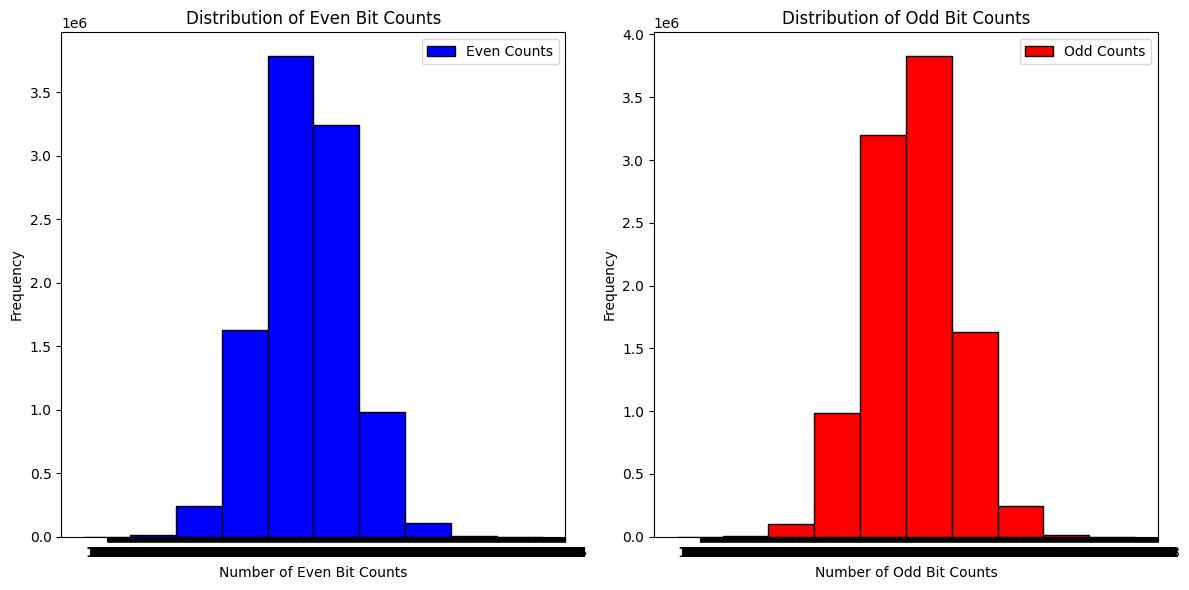

In [6]:

def plot_results(even_counts, odd_counts):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(even_counts, color='blue', label='Even Counts', edgecolor='black', align='left')
    plt.xlabel('Number of Even Bit Counts')
    plt.ylabel('Frequency')
    plt.title('Distribution of Even Bit Counts')
    plt.xticks(range(min(even_counts), max(even_counts) + 1))
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(odd_counts, color='red', label='Odd Counts', edgecolor='black', align='left')
    plt.xlabel('Number of Odd Bit Counts')
    plt.ylabel('Frequency')
    plt.title('Distribution of Odd Bit Counts')
    plt.xticks(range(min(odd_counts), max(odd_counts) + 1))
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_results(even_counts, odd_counts)

# Compare 1-bit odd count MIC/Cipher distribution
To evaluate the cryptography implementation of the protocol, a good thing to do is show the distribution using a test. This test is a mask in the following range: $[0-2^{32}]$. 
The logic is to take the current mask $m$ and compute  logical AND operation with 1st 32 bits block of the MIC/Ciphertext value as follows: 
- $r = m \land ciphertext_{[0..31]}$ where $r$ is the result of the operation.
- $r = m \land mic_{[0..31]}$ where $r$ is the result of the operation.

After that, count the odd 1-bit occurence and store it in a vector.

The expected result of the distribution for both should be Gaussian.



101
98


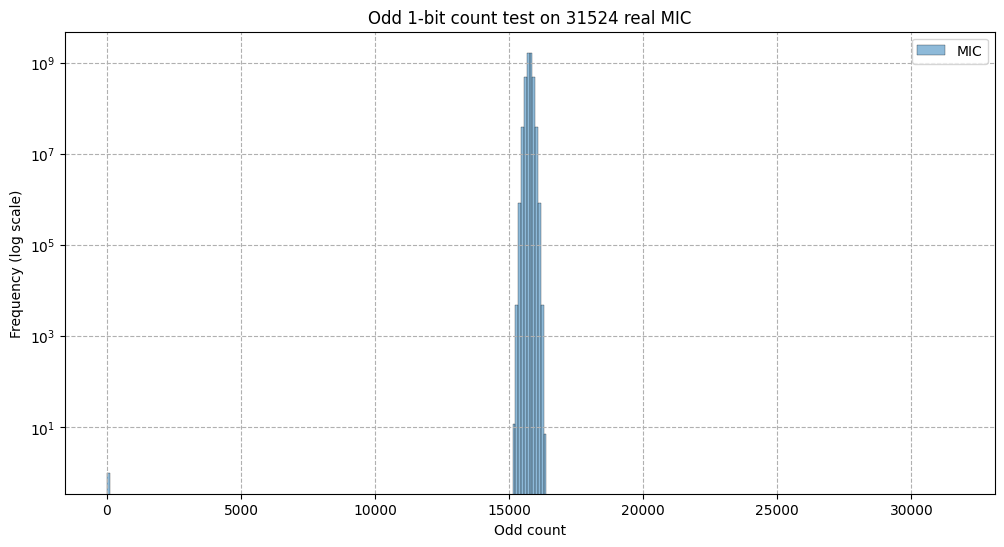

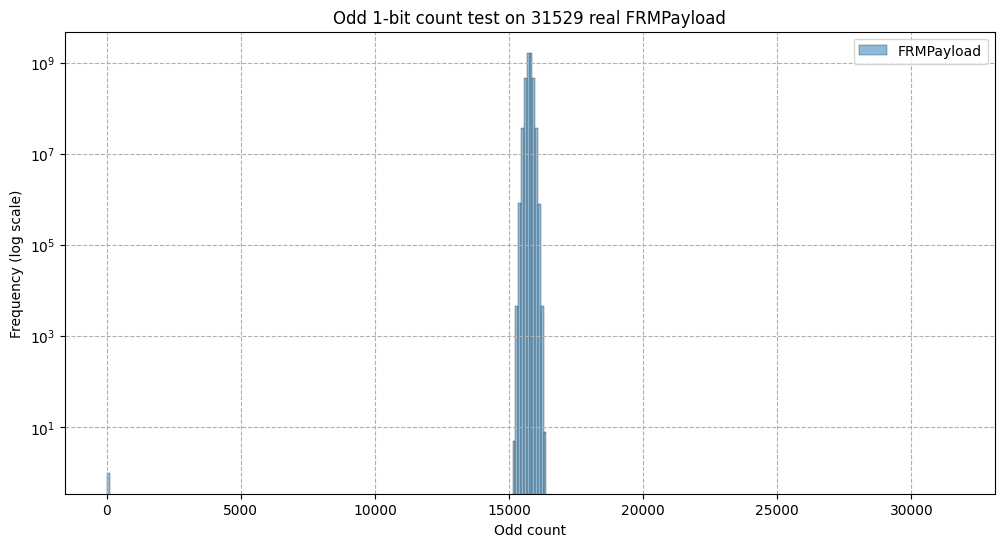

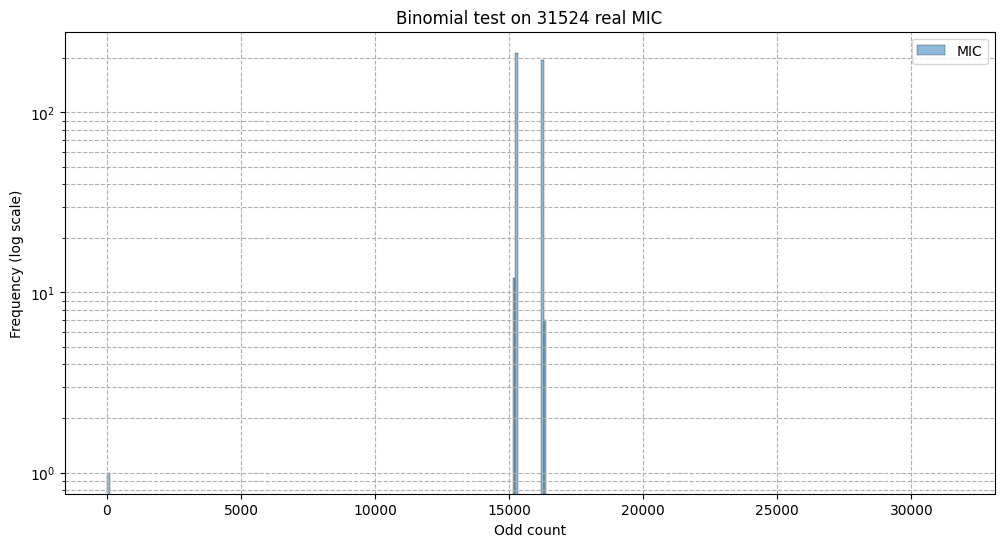

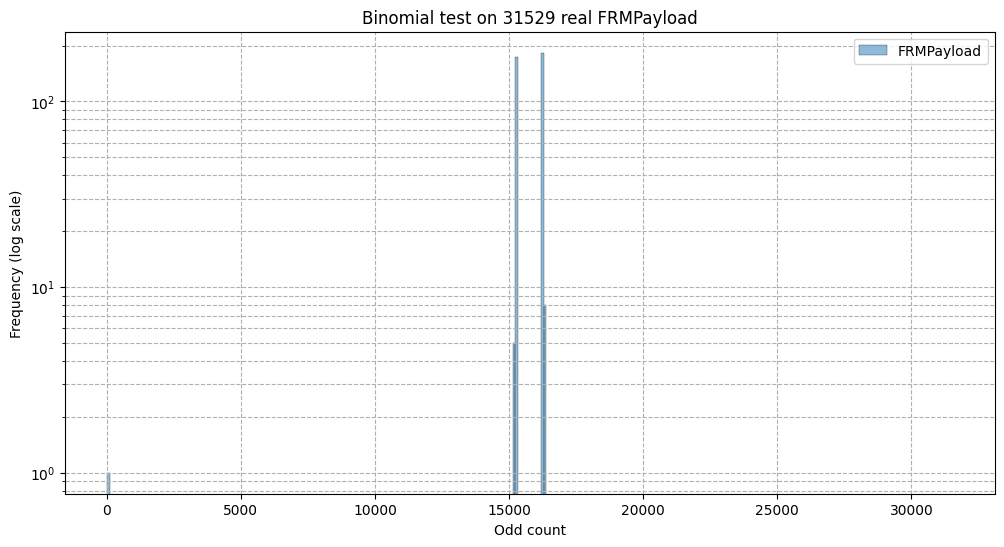

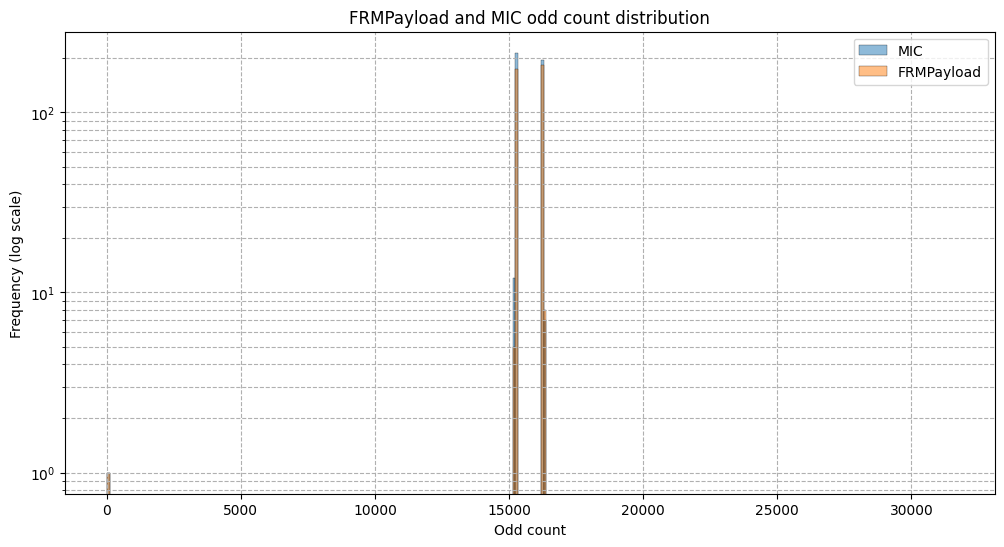

In [40]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def load_data(file_path, key):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data[key]

def plot_histogram(x_data, weights, bins, label, title):
    plt.figure(figsize=(12, 6))
    sns.histplot(x=x_data, weights=weights, bins=bins, label=label, alpha=0.5)
    plt.yscale('log')
    plt.xlabel('Odd count')
    plt.ylabel('Frequency (log scale)')
    plt.title(title)
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

# load all data
mac_odd = load_data('./test_bit_quality/31523_real_odd_test_mac.json', 'counters')
ciphertexts_odd = load_data('./test_bit_quality/31528_real_odd_test_ciphertexts.json', 'counters')
mac_binomial = load_data('./test_bit_quality/31523_real_binomial_test_mac.json', 'invalid_odd')
ciphertexts_binomial = load_data('./test_bit_quality/31528_real_binomial_test_ciphertexts.json', 'invalid_odd')

# len of odd that reject h0
print(len([x for x in mac_binomial if x != 0]))
print(len([x for x in ciphertexts_binomial if x != 0]))

# prepare data for plots
len_mac_odd = np.arange(len(mac_odd))
len_ciphertexts_odd = np.arange(len(ciphertexts_odd))
len_mac_binomial = np.arange(len(mac_binomial))
len_ciphertexts_binomial = np.arange(len(ciphertexts_binomial))

# plot 4 hist, 2 by test
plot_histogram(len_mac_odd, mac_odd, bins=300, label='MIC', title=f'Odd 1-bit count test on {len(mac_odd)} real MIC')
plot_histogram(len_ciphertexts_odd, ciphertexts_odd, bins=300, label='FRMPayload', title=f'Odd 1-bit count test on {len(ciphertexts_odd)} real FRMPayload')
plot_histogram(len_mac_binomial, mac_binomial, bins=300, label='MIC', title=f'Binomial test on {len(mac_binomial)} real MIC')
plot_histogram(len_ciphertexts_binomial, ciphertexts_binomial, bins=300, label='FRMPayload', title=f'Binomial test on {len(ciphertexts_binomial)} real FRMPayload')

# Compare distributions in a single plot
plt.figure(figsize=(12, 6))
sns.histplot(x=len_mac_binomial, weights=mac_binomial, bins=300, label='MIC', alpha=0.5)
sns.histplot(x=len_ciphertexts_binomial, weights=ciphertexts_binomial, bins=300, label='FRMPayload', alpha=0.5)
plt.yscale('log')
plt.xlabel('Odd count')
plt.ylabel('Frequency (log scale)')
plt.title('FRMPayload and MIC odd count distribution')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()
